In [1]:
import pandas as pd
import cupy as cp
import cubewalkers as cw
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
%matplotlib inline

plt.rcParams.update({'font.size':20})

In [51]:
QCF = pd.read_csv('data/quasicoherence_fuzzy.csv')
QC = pd.read_csv('data/quasicoherence_nonfuzzy.csv')
QCFNS = pd.read_csv('data/quasicoherence_fuzzy_nosource.csv')
QCNS = pd.read_csv('data/quasicoherence_nonfuzzy_nosource.csv')
QC = QC.merge(QCF)
QC = QC.merge(QCNS)
QC = QC.merge(QCFNS)
QC.columns = ['name', 'SQC', 'AQC', 'SFQC', 'AFQC', 'SQCNS', 'AQCNS', 'SFQCNS', 'AFQCNS']
QC['dQC'] = QC['SQC']-QC['AQC']
QC['dFQC'] = QC['SFQC']-QC['AFQC']
QC


,name,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,dQC,dFQC
0,Apoptosis Network,0.902,0.903,0.976,0.975,0.902,0.903,0.941,0.943,-0.001,0.001
1,Arabidopsis thaliana Cell Cycle,1.000,0.913,0.998,0.972,1.000,0.913,0.998,0.972,0.087,0.026
2,Aurora Kinase A in Neuroblastoma,0.762,0.771,0.944,0.941,0.761,0.771,0.798,0.794,-0.009,0.003
3,B bronchiseptica and T retortaeformis coinfection,0.911,0.924,0.991,0.988,0.911,0.925,0.974,0.972,-0.013,0.003
4,B cell differentiation,0.735,0.739,0.957,0.956,0.735,0.740,0.765,0.765,-0.004,0.001
...,...,...,...,...,...,...,...,...,...,...,...
69,Trichostrongylus retortaeformis,0.845,0.880,0.973,0.971,0.846,0.881,0.942,0.942,-0.035,0.002
70,Tumour Cell Invasion and Migration,0.883,0.896,0.964,0.960,0.881,0.897,0.919,0.918,-0.013,0.004
71,VEGF Pathway of Drosophila Signaling Pathway,0.556,0.556,0.957,0.958,0.556,0.556,0.556,0.556,0.000,-0.001
72,Wg Pathway of Drosophila Signalling Pathways,0.462,0.462,0.964,0.964,0.462,0.462,0.462,0.461,0.000,0.000


In [52]:
DC = pd.read_csv('data/derrida_coefficients.csv',header=None)
DC.columns=['name','s','SDC','a','ADC']
DC = DC.drop(['s','a'],axis=1)

QC=QC.merge(DC)
QC

,name,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,dQC,dFQC,SDC,ADC
0,Apoptosis Network,0.902,0.903,0.976,0.975,0.902,0.903,0.941,0.943,-0.001,0.001,1.010,1.031
1,Arabidopsis thaliana Cell Cycle,1.000,0.913,0.998,0.972,1.000,0.913,0.998,0.972,0.087,0.026,1.271,1.219
2,Aurora Kinase A in Neuroblastoma,0.762,0.771,0.944,0.941,0.761,0.771,0.798,0.794,-0.009,0.003,1.051,1.066
3,B bronchiseptica and T retortaeformis coinfection,0.911,0.924,0.991,0.988,0.911,0.925,0.974,0.972,-0.013,0.003,1.012,0.996
4,B cell differentiation,0.735,0.739,0.957,0.956,0.735,0.740,0.765,0.765,-0.004,0.001,1.000,1.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Trichostrongylus retortaeformis,0.845,0.880,0.973,0.971,0.846,0.881,0.942,0.942,-0.035,0.002,1.012,1.034
70,Tumour Cell Invasion and Migration,0.883,0.896,0.964,0.960,0.881,0.897,0.919,0.918,-0.013,0.004,0.727,0.906
71,VEGF Pathway of Drosophila Signaling Pathway,0.556,0.556,0.957,0.958,0.556,0.556,0.556,0.556,0.000,-0.001,0.962,0.954
72,Wg Pathway of Drosophila Signalling Pathways,0.462,0.462,0.964,0.964,0.462,0.462,0.462,0.461,0.000,0.000,0.972,0.991


In [63]:
names = []
SFHD = []
AFHD = []

with open('data/hamming_distances.csv', 'r') as f:
    for row in f:
        entries = row.split(',')
        name = entries.pop(0)
        scheme = entries.pop(0)
        fhd = float(entries.pop())
        
        if scheme == 'synchronous':
            names.append(name)
            SFHD.append(fhd)
        elif scheme == 'asynchronous':
            AFHD.append(fhd)

N = []
Ns = []
# with open('data/converged_average_node_values.csv') as f:
#     for row in f:
#         entries = row.split(',')
#         name = entries.pop(0)
#         convergence_score = entries.pop(0)
#         scheme = entries.pop(0)
#         if scheme == 'synchronous':
#             N.append(len(entries))

for name in sorted(names):
    with open(f'models/cell_collective/{name}.txt') as f:
        nt = 0
        ns = 0
        for row in f:
            nt += 1
            if row.split(',')[0].strip() == row.split(',')[1].strip():
                ns += 1
        N.append(nt)
        Ns.append(ns)

HD = pd.DataFrame({
    'name': names,
    'SFHD': SFHD,
    'AFHD': AFHD,
    'N': N,
    'Ns': Ns,
})

QC=QC.merge(HD)
QC

,name,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,Ns
0,Apoptosis Network,0.902,0.903,0.976,0.975,0.902,0.903,0.941,0.943,-0.001,0.001,1.010,1.031,1.431,1.269,41,2
1,Arabidopsis thaliana Cell Cycle,1.000,0.913,0.998,0.972,1.000,0.913,0.998,0.972,0.087,0.026,1.271,1.219,1.548,1.213,14,0
2,Aurora Kinase A in Neuroblastoma,0.762,0.771,0.944,0.941,0.761,0.771,0.798,0.794,-0.009,0.003,1.051,1.066,1.973,1.367,23,4
3,B bronchiseptica and T retortaeformis coinfection,0.911,0.924,0.991,0.988,0.911,0.925,0.974,0.972,-0.013,0.003,1.012,0.996,0.589,0.867,53,1
4,B cell differentiation,0.735,0.739,0.957,0.956,0.735,0.740,0.765,0.765,-0.004,0.001,1.000,1.016,0.936,0.991,22,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Trichostrongylus retortaeformis,0.845,0.880,0.973,0.971,0.846,0.881,0.942,0.942,-0.035,0.002,1.012,1.034,0.905,0.984,26,1
70,Tumour Cell Invasion and Migration,0.883,0.896,0.964,0.960,0.881,0.897,0.919,0.918,-0.013,0.004,0.727,0.906,1.220,1.273,32,2
71,VEGF Pathway of Drosophila Signaling Pathway,0.556,0.556,0.957,0.958,0.556,0.556,0.556,0.556,0.000,-0.001,0.962,0.954,0.761,0.744,18,8
72,Wg Pathway of Drosophila Signalling Pathways,0.462,0.462,0.964,0.964,0.462,0.462,0.462,0.461,0.000,0.000,0.972,0.991,0.941,0.956,26,14


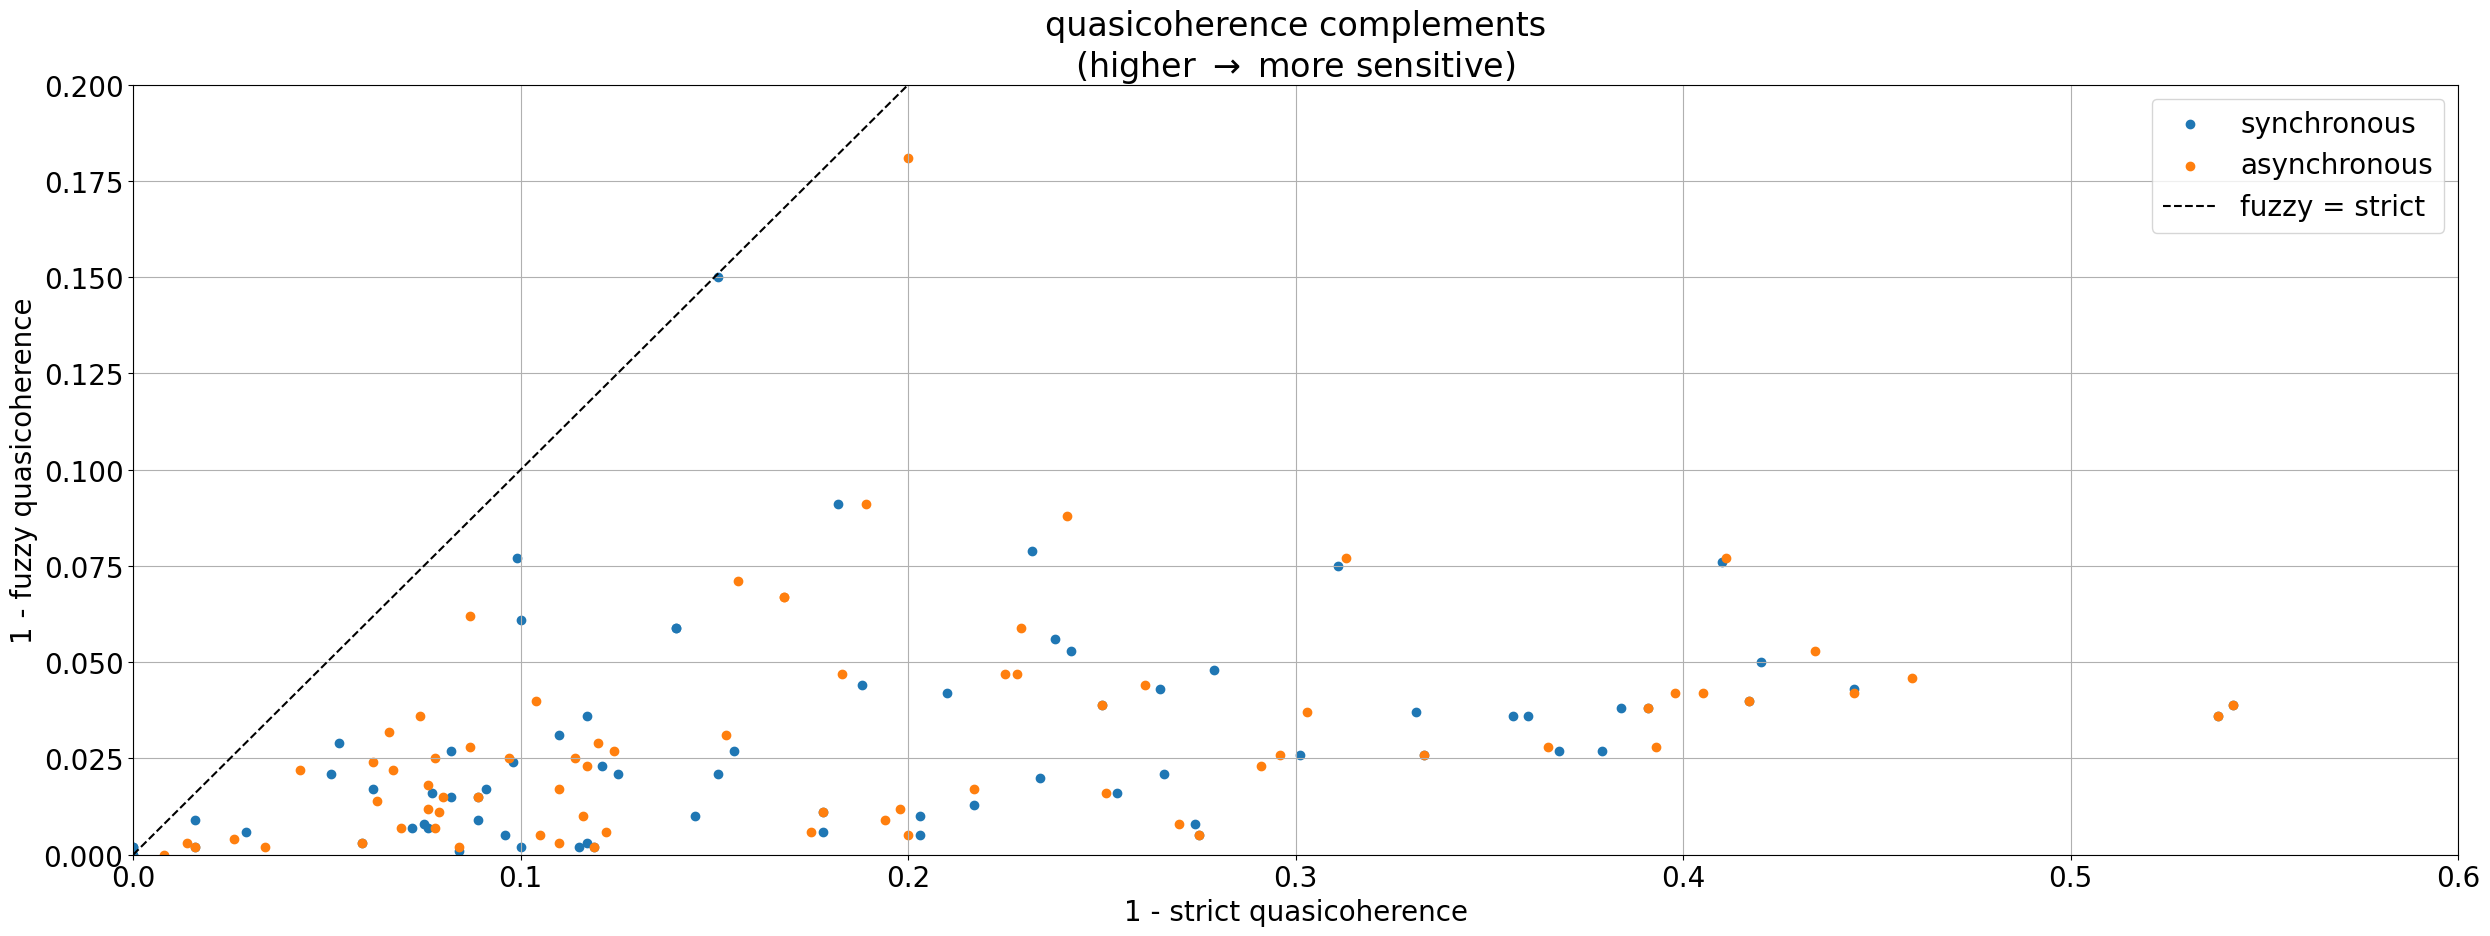

In [60]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')
ax.scatter(1-QC['SQC'],1-QC['SFQC'],label='synchronous')
ax.scatter(1-QC['AQC'],1-QC['AFQC'],label='asynchronous')
ax.axline((0,0),slope=1,linestyle='--',color='k',label='fuzzy = strict')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.2)
ax.grid()
ax.set_xlabel('1 - strict quasicoherence')
ax.set_ylabel('1 - fuzzy quasicoherence')
ax.legend(loc='upper right')
ax.set_title(f'quasicoherence complements\n(higher $\\rightarrow$ more sensitive)')
plt.show()

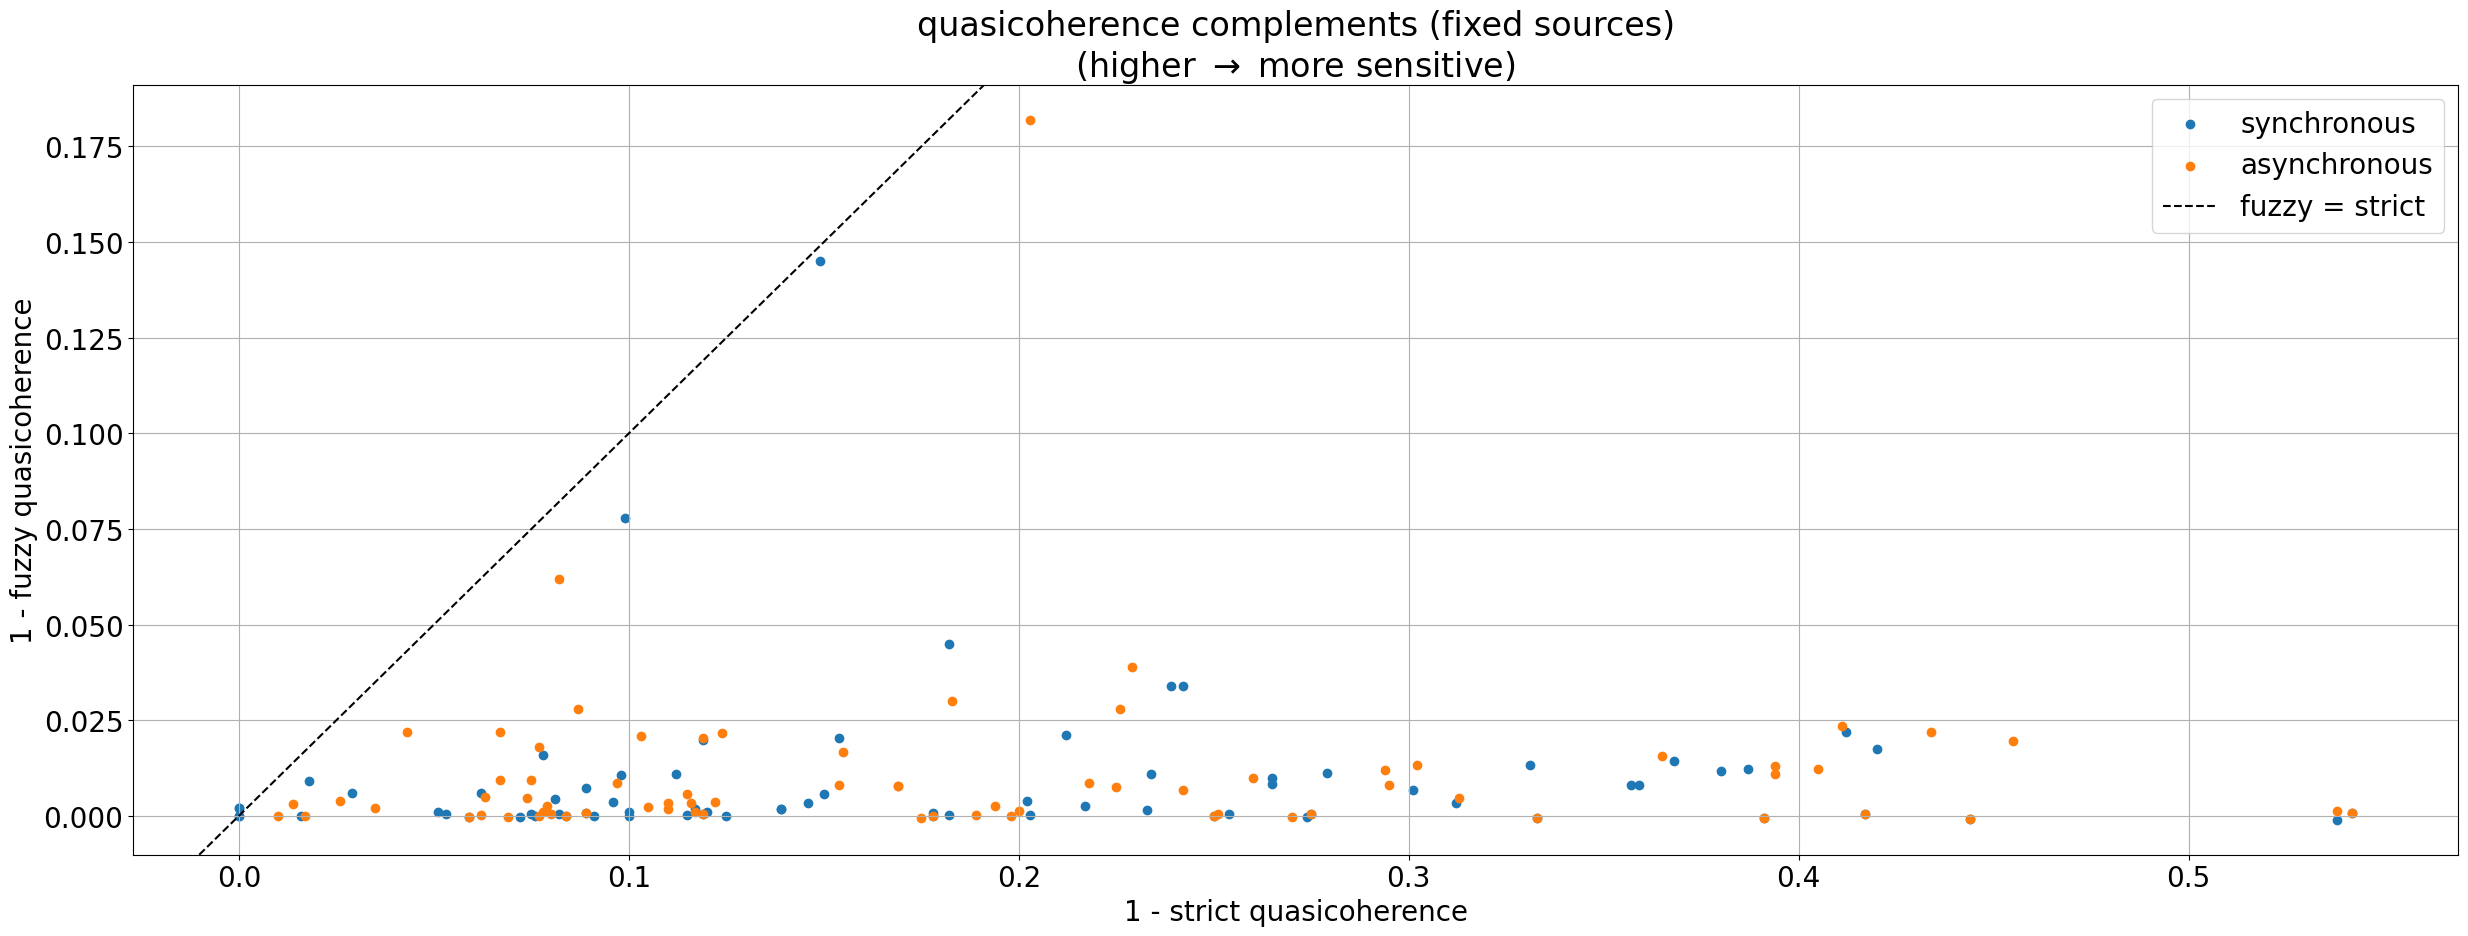

In [87]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')
ax.scatter(1-QC['SQCNS'],1-QC['SFQCNS']*(QC['N']/(QC['N']-QC['Ns'])),label='synchronous')
ax.scatter(1-QC['AQCNS'],1-QC['AFQCNS']*(QC['N']/(QC['N']-QC['Ns'])),label='asynchronous')
ax.axline((0,0),slope=1,linestyle='--',color='k',label='fuzzy = strict')
#ax.set_xlim(0,0.6)
#ax.set_ylim(0,0.2)
ax.grid()
ax.set_xlabel('1 - strict quasicoherence')
ax.set_ylabel('1 - fuzzy quasicoherence')
ax.legend(loc='upper right')
ax.set_title(f'quasicoherence complements (fixed sources)\n(higher $\\rightarrow$ more sensitive)')
plt.show()

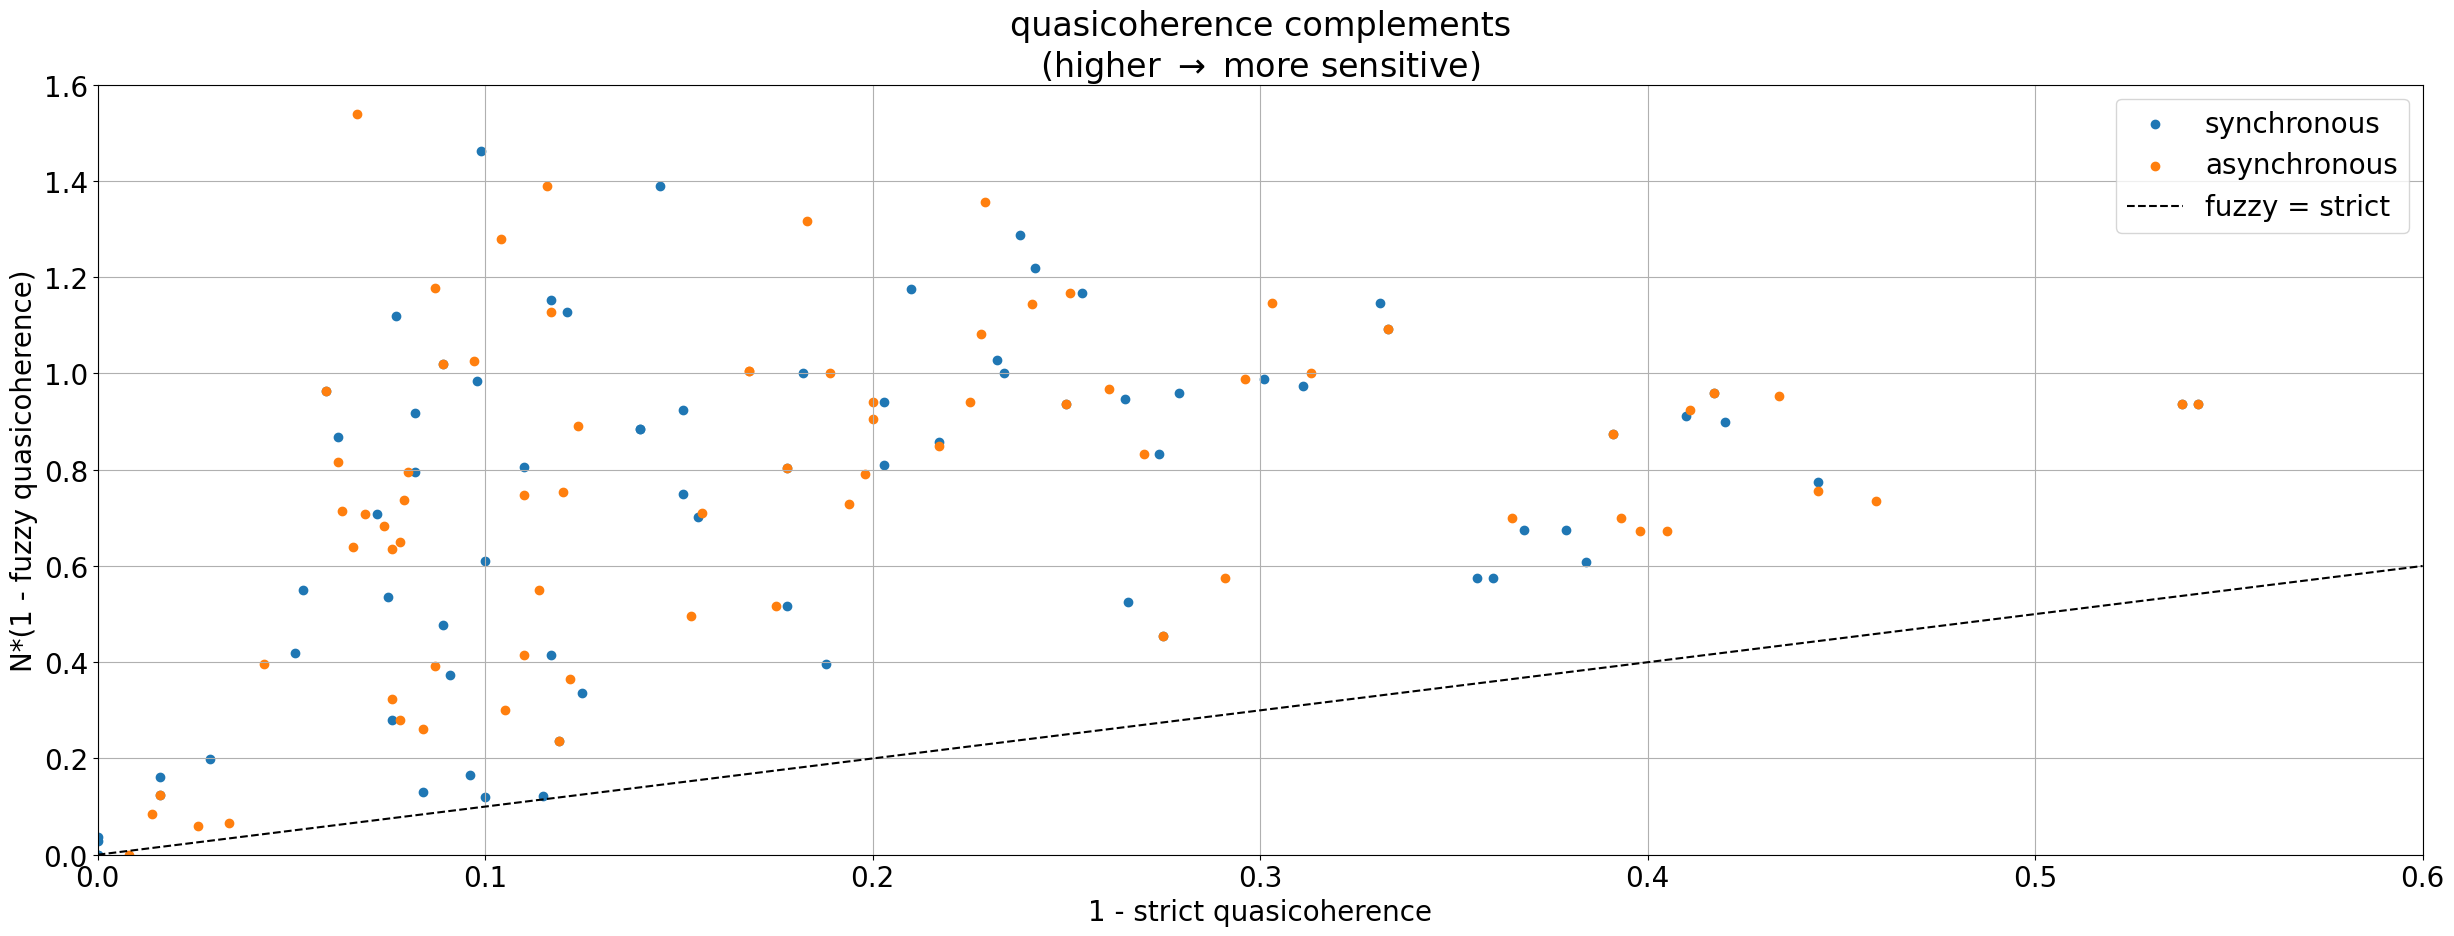

In [61]:
fig,ax = plt.subplots(1,1,figsize=(30,10))
fig.set_facecolor('white')
ax.scatter(1-QC['SQC'],(QC['N'])*(1-QC['SFQC']),label='synchronous')
ax.scatter(1-QC['AQC'],(QC['N'])*(1-QC['AFQC']),label='asynchronous')
ax.axline((0,0),slope=1,linestyle='--',color='k',label='fuzzy = strict')
ax.set_xlim(0,0.6)
ax.set_ylim(0,1.6)
ax.grid()
ax.set_xlabel('1 - strict quasicoherence')
ax.set_ylabel('N*(1 - fuzzy quasicoherence)')
ax.legend(loc='upper right')
ax.set_title(f'quasicoherence complements\n(higher $\\rightarrow$ more sensitive)')
plt.show()

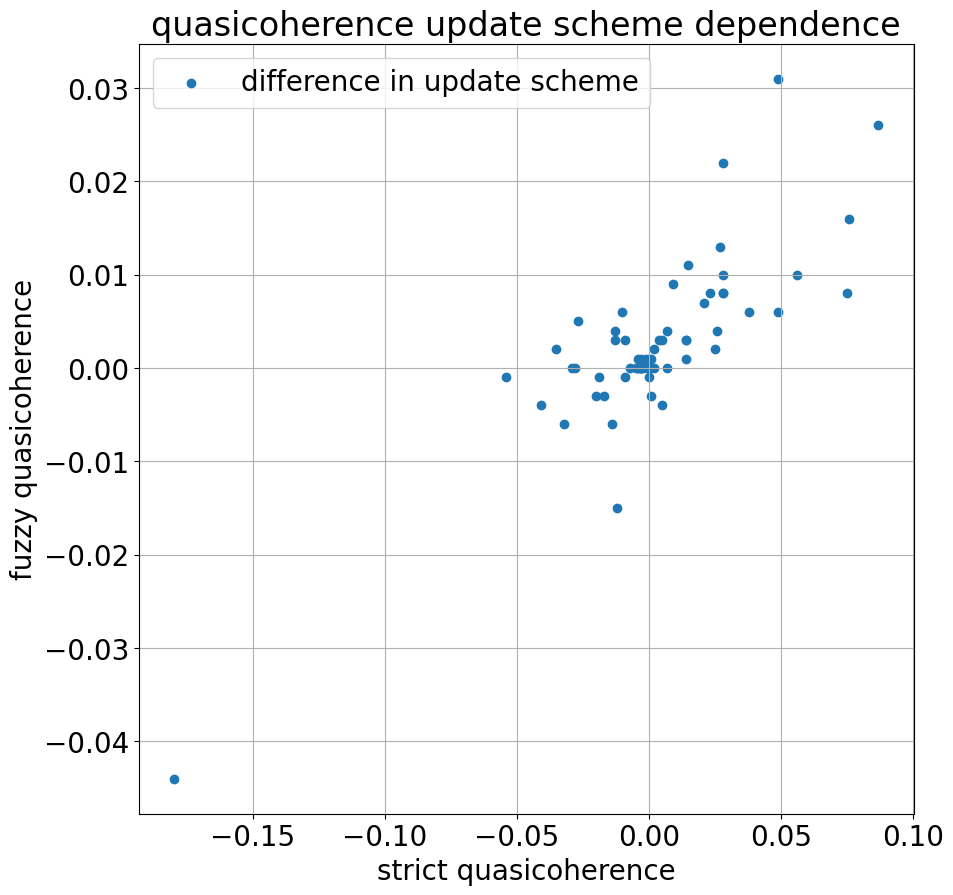

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(QC['dQC'],QC['dFQC'],label='difference in update scheme')
#ax.plot(1-np.arange(0,2,0.1),1-np.arange(0,2,0.1),'k--',label='fuzzy = strict')
#ax.set_xlim(0,0.6)
#ax.set_ylim(0,0.2)
ax.grid()
ax.set_xlabel('strict quasicoherence')
ax.set_ylabel('fuzzy quasicoherence')
ax.legend(loc='upper left')
ax.set_title(f'quasicoherence update scheme dependence')
plt.show()

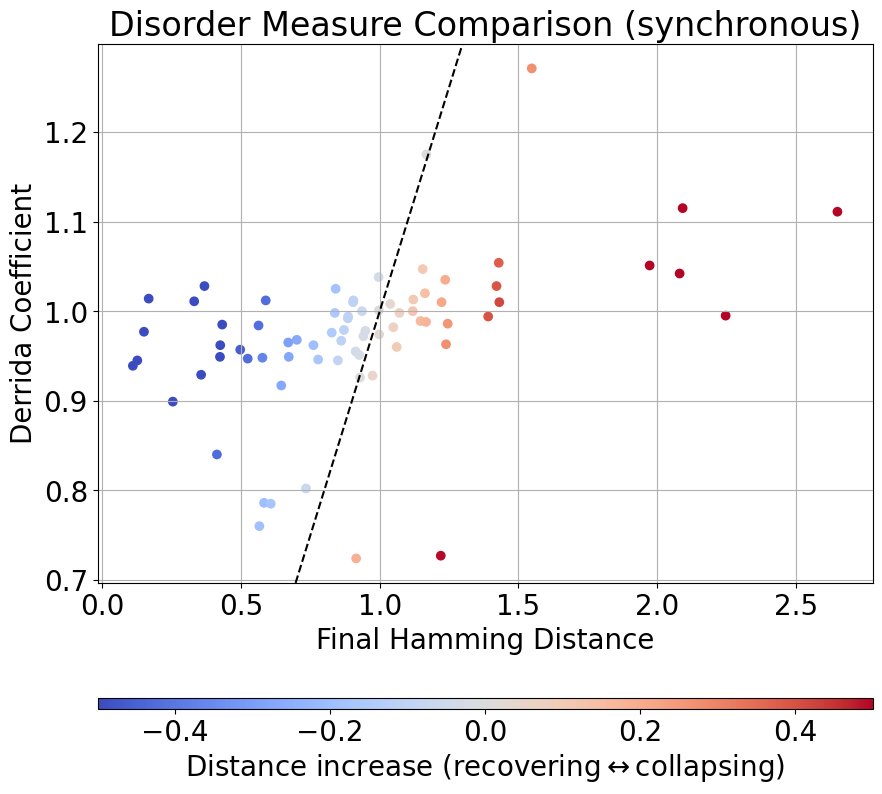

In [8]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
cmap = plt.cm.get_cmap('coolwarm')
sc=ax.scatter(QC['SFHD'],QC['SDC'],c=QC['SFHD']-QC['SDC'],cmap=cmap, norm=CenteredNorm(vcenter=0,halfrange=0.5))
ax.axline((1,1),slope=1,linestyle='--',color='k')
cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.set_label('Distance increase (recovering$\leftrightarrow$collapsing)')
ax.grid()
ax.set_xlabel('Final Hamming Distance')
ax.set_ylabel('Derrida Coefficient')
ax.set_title(f'Disorder Measure Comparison (synchronous)')
plt.show()

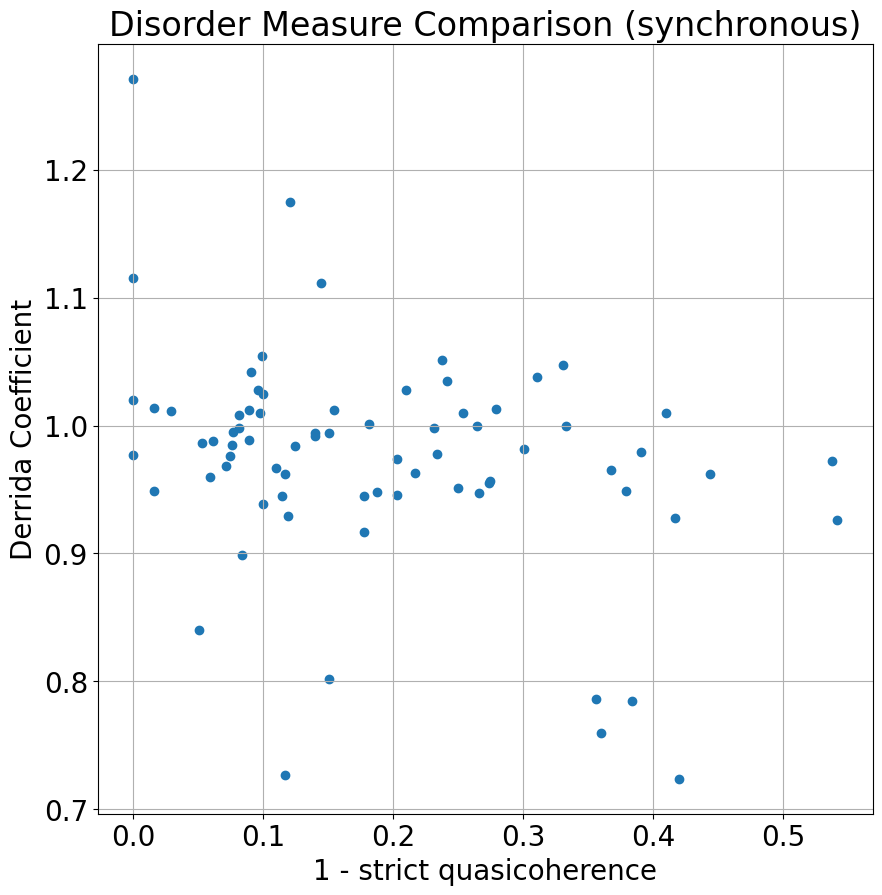

In [9]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(1-QC['SQC'],QC['SDC'])
ax.grid()
ax.set_xlabel('1 - strict quasicoherence')
ax.set_ylabel('Derrida Coefficient')
ax.set_title(f'Disorder Measure Comparison (synchronous)')
plt.show()

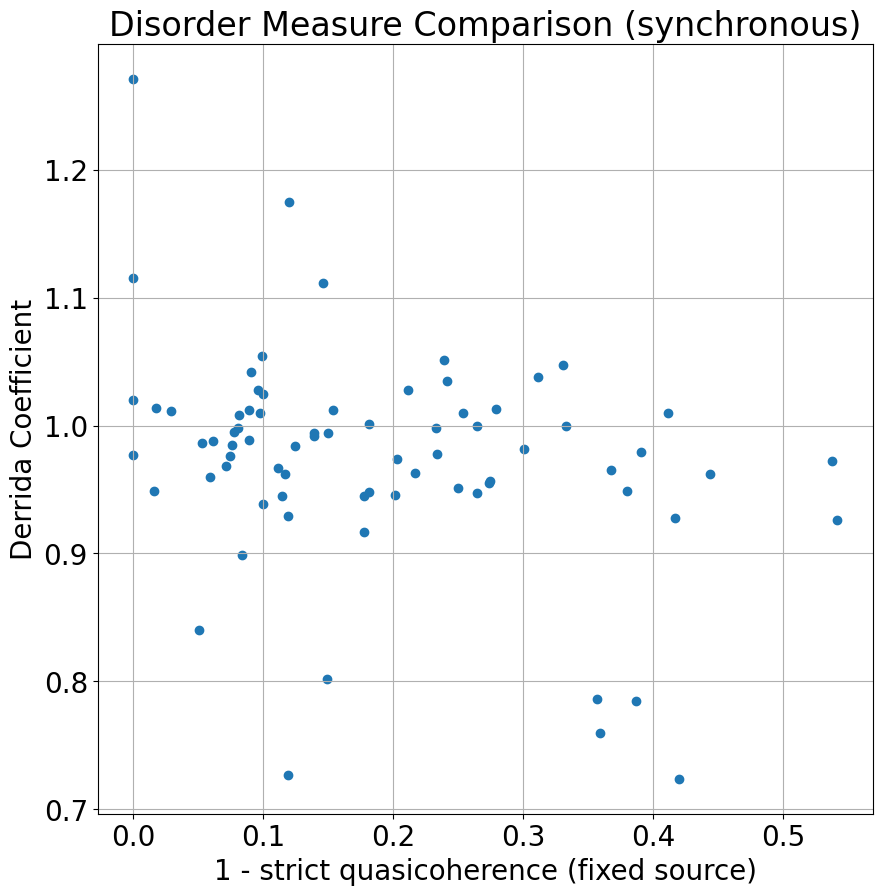

In [93]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(1-QC['SQCNS'],QC['SDC'])
ax.grid()
ax.set_xlabel('1 - strict quasicoherence (fixed source)')
ax.set_ylabel('Derrida Coefficient')
ax.set_title(f'Disorder Measure Comparison (synchronous)')
plt.show()

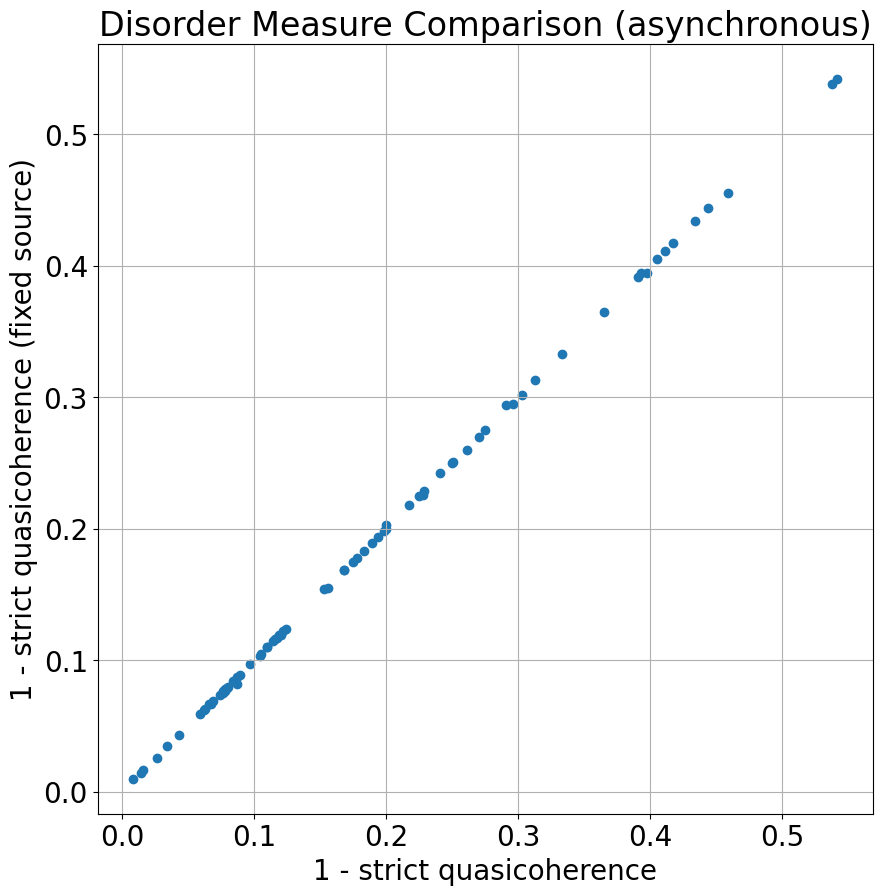

In [81]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(1-QC['AQC'],1-QC['AQCNS'])
ax.grid()
ax.set_xlabel('1 - strict quasicoherence')
ax.set_ylabel('1 - strict quasicoherence (fixed source)')
ax.set_title(f'Disorder Measure Comparison (asynchronous)')
plt.show()

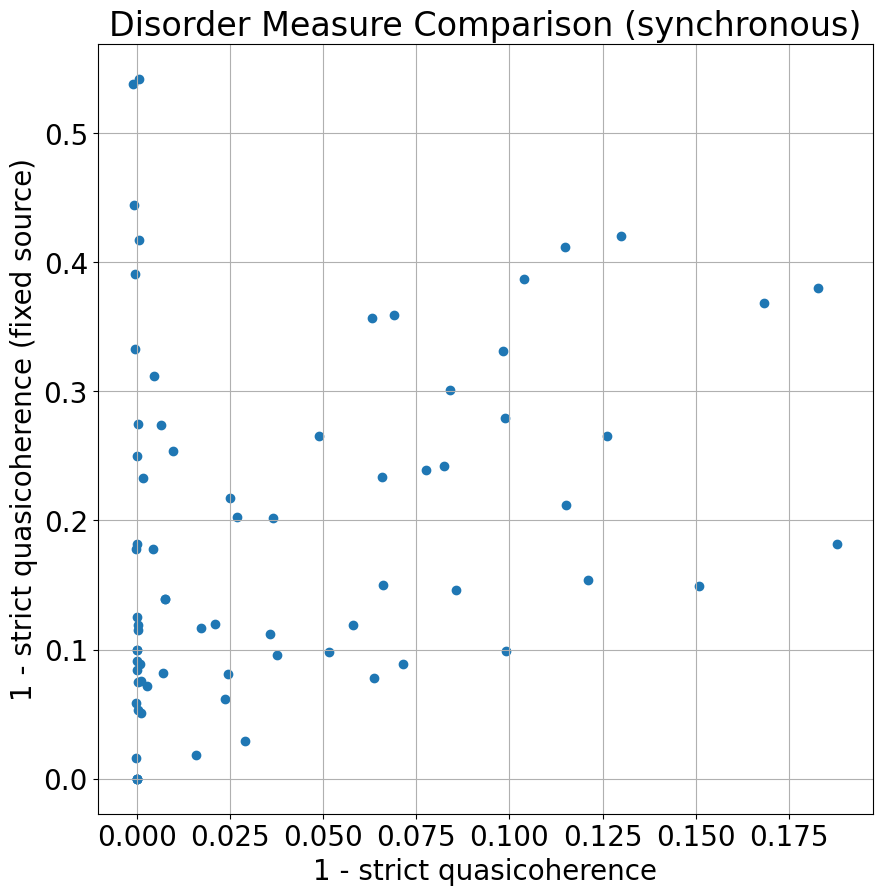

In [94]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(1-QC['SQC']*QC['N']/(QC['N']-QC['Ns']),1-QC['SQCNS'])
ax.grid()
ax.set_xlabel('1 - strict quasicoherence')
ax.set_ylabel('1 - strict quasicoherence (fixed source)')
ax.set_title(f'Disorder Measure Comparison (synchronous)')
plt.show()

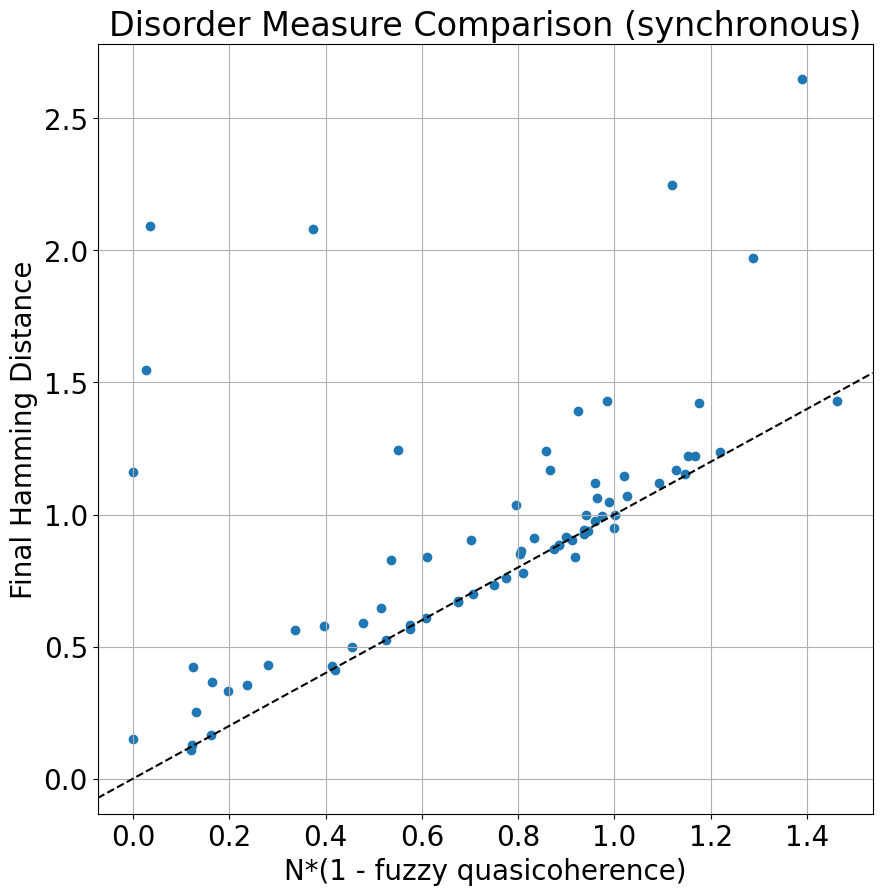

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter((1-QC['SFQC'])*QC['N'],QC['SFHD'])
ax.axline((0,0),slope=1,linestyle='--',color='k')
ax.grid()
ax.set_xlabel('N*(1 - fuzzy quasicoherence)')
ax.set_ylabel('Final Hamming Distance')
ax.set_title(f'Disorder Measure Comparison (synchronous)')
plt.show()

**Note on above plot:**

There are a few reasons the correlation is not perfect. In order of conjectured significance, they are:
1) coherence is not sensitive to phase shifts, but Hamming distance is
2) the coherence calculation waits for convergence, but the Hamming distance is measured at a fixed cutoff
3) these were run with different samples


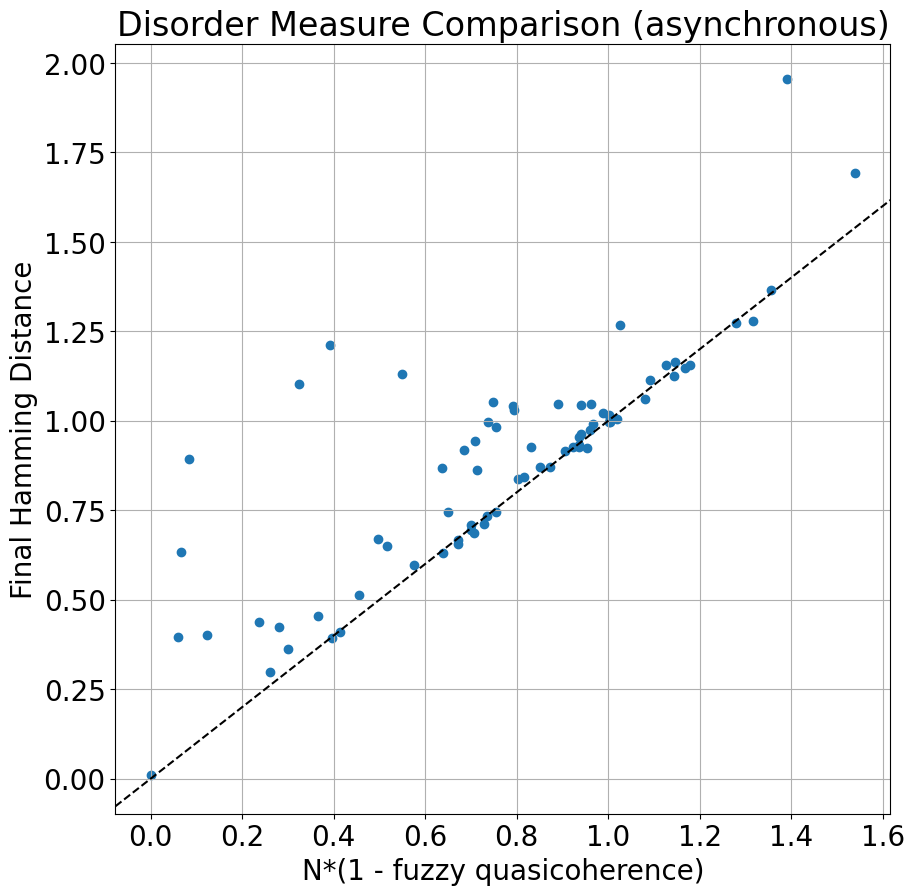

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter((1-QC['AFQC'])*QC['N'],QC['AFHD'])
ax.axline((0,0),slope=1,linestyle='--',color='k')
ax.grid()
ax.set_xlabel('N*(1 - fuzzy quasicoherence)')
ax.set_ylabel('Final Hamming Distance')
ax.set_title(f'Disorder Measure Comparison (asynchronous)')
plt.show()

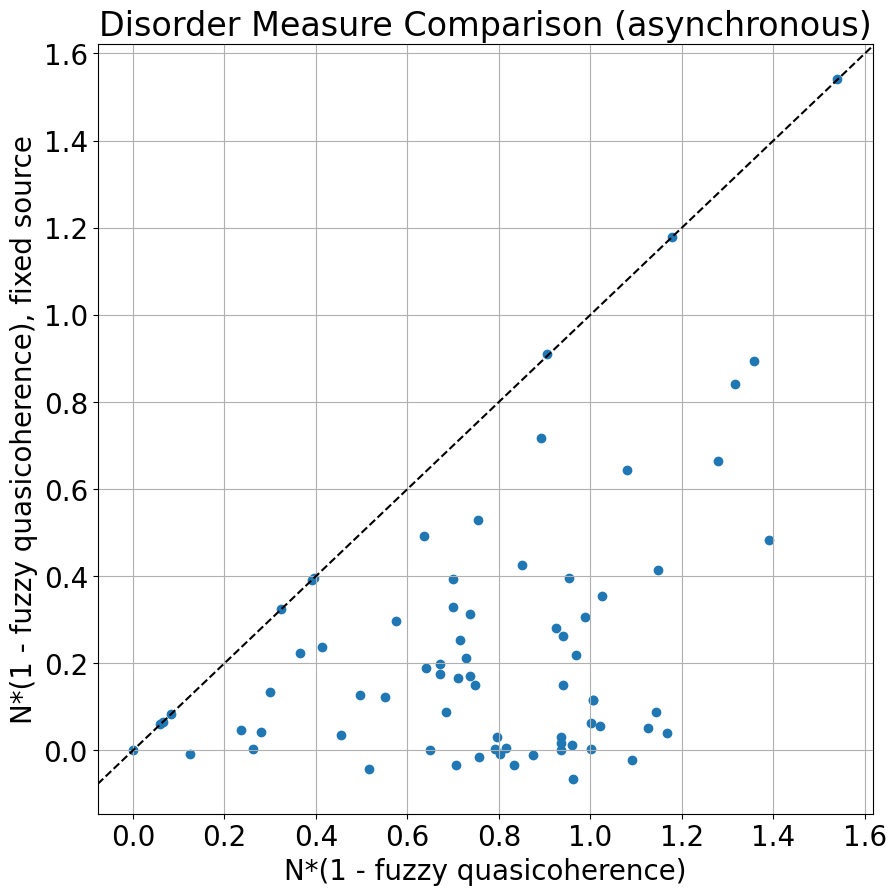

In [88]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter((1-QC['AFQC'])*QC['N'],(1-QC['AFQCNS']*(QC['N']/(QC['N']-QC['Ns'])))*(QC['N']))
ax.axline((0,0),slope=1,linestyle='--',color='k')
ax.grid()
ax.set_xlabel('N*(1 - fuzzy quasicoherence)')
ax.set_ylabel('N*(1 - fuzzy quasicoherence), fixed source')
ax.set_title(f'Disorder Measure Comparison (asynchronous)')
plt.show()

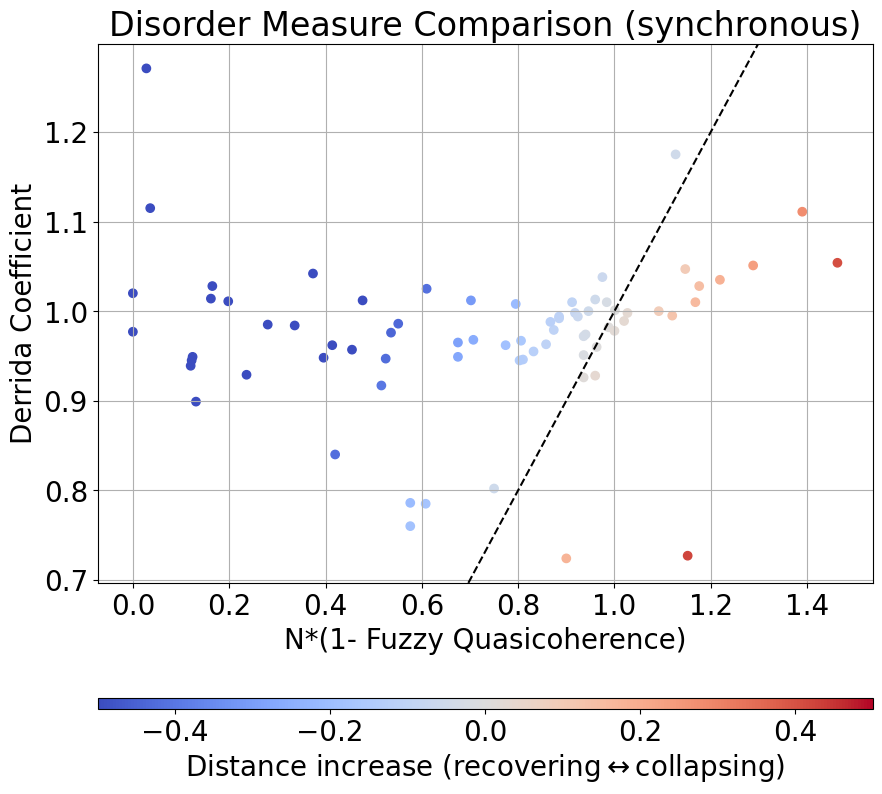

In [57]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
cmap = plt.cm.get_cmap('coolwarm')
sc=ax.scatter((1-QC['SFQC'])*QC['N'],QC['SDC'],c=(1-QC['SFQC'])*QC['N']-QC['SDC'],cmap=cmap, norm=CenteredNorm(vcenter=0,halfrange=0.5))
ax.axline((1,1),slope=1,linestyle='--',color='k')
cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.set_label('Distance increase (recovering$\leftrightarrow$collapsing)')
ax.grid()
ax.set_xlabel('N*(1- Fuzzy Quasicoherence)')
ax.set_ylabel('Derrida Coefficient')
ax.set_title(f'Disorder Measure Comparison (synchronous)')
plt.show()

In [58]:
QC.sort_values(by=['SFQCNS'])

,name,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,Ns
30,HH Pathway of Drosophila Signaling Pathways,0.458,0.458,0.961,0.961,0.458,0.458,0.458,0.458,0.000,0.000,0.926,0.951,0.929,0.933,24,13
72,Wg Pathway of Drosophila Signalling Pathways,0.462,0.462,0.964,0.964,0.462,0.462,0.462,0.461,0.000,0.000,0.972,0.991,0.941,0.956,26,14
71,VEGF Pathway of Drosophila Signaling Pathway,0.556,0.556,0.957,0.958,0.556,0.556,0.556,0.556,0.000,-0.001,0.962,0.954,0.761,0.744,18,8
66,TOL Regulatory Network,0.583,0.583,0.960,0.960,0.583,0.583,0.583,0.583,0.000,0.000,0.928,0.961,0.974,0.975,24,10
23,FGF pathway of Drosophila Signalling Pathways,0.609,0.609,0.962,0.962,0.609,0.609,0.609,0.609,0.000,0.000,0.979,0.980,0.871,0.870,23,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Bordetella bronchiseptica,0.971,0.966,0.994,0.998,0.971,0.965,0.994,0.998,0.005,-0.004,1.011,0.995,0.331,0.633,33,0
10,Budding Yeast Cell Cycle 2009,1.000,0.924,0.998,0.982,1.000,0.923,0.998,0.982,0.076,0.016,1.115,1.119,2.092,1.103,18,0
1,Arabidopsis thaliana Cell Cycle,1.000,0.913,0.998,0.972,1.000,0.913,0.998,0.972,0.087,0.026,1.271,1.219,1.548,1.213,14,0
22,FA BRCA pathway,1.000,0.986,1.000,0.997,1.000,0.986,1.000,0.997,0.014,0.003,1.020,1.034,1.163,0.894,28,0


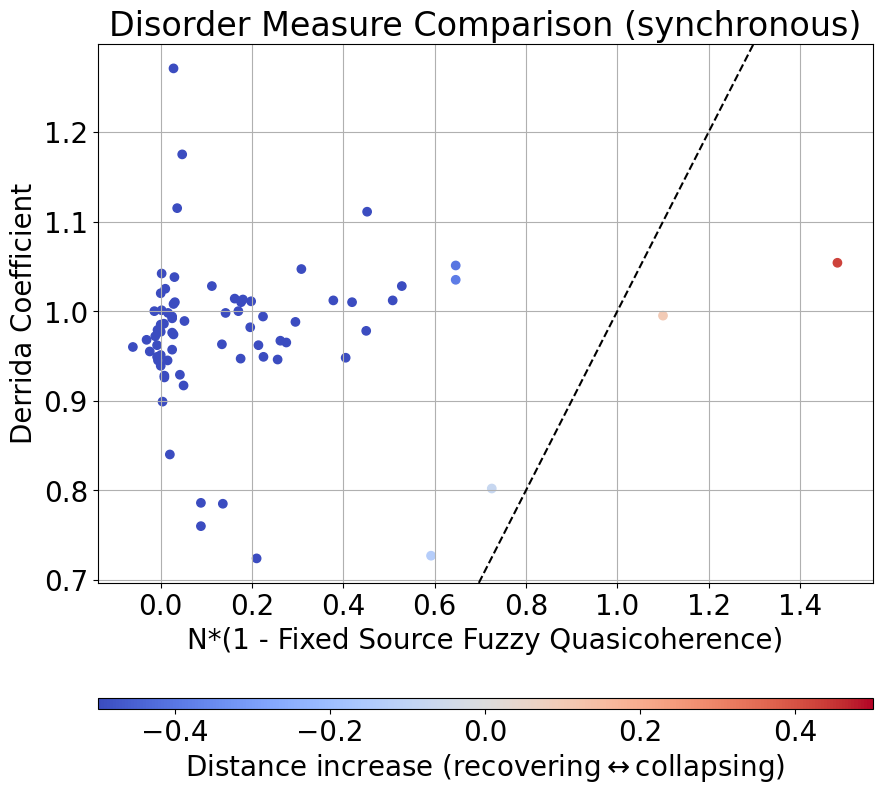

In [92]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
cmap = plt.cm.get_cmap('coolwarm')
sc=ax.scatter(
    (1-QC['SFQCNS']*(QC['N']/(QC['N']-QC['Ns'])))*(QC['N']-QC['Ns']),
    QC['SDC'],
    c=(1-QC['SFQCNS']*(QC['N']/(QC['N']-QC['Ns'])))*(QC['N']-QC['Ns'])-QC['SDC'],
    cmap=cmap, 
    norm=CenteredNorm(vcenter=0,halfrange=0.5))
ax.axline((1,1),slope=1,linestyle='--',color='k')
cbar=fig.colorbar(sc,ax=ax,location='bottom',aspect=75)
cbar.set_label('Distance increase (recovering$\leftrightarrow$collapsing)')
ax.grid()
ax.set_xlabel('N*(1 - Fixed Source Fuzzy Quasicoherence)')
ax.set_ylabel('Derrida Coefficient')
ax.set_title(f'Disorder Measure Comparison (synchronous)')
plt.show()

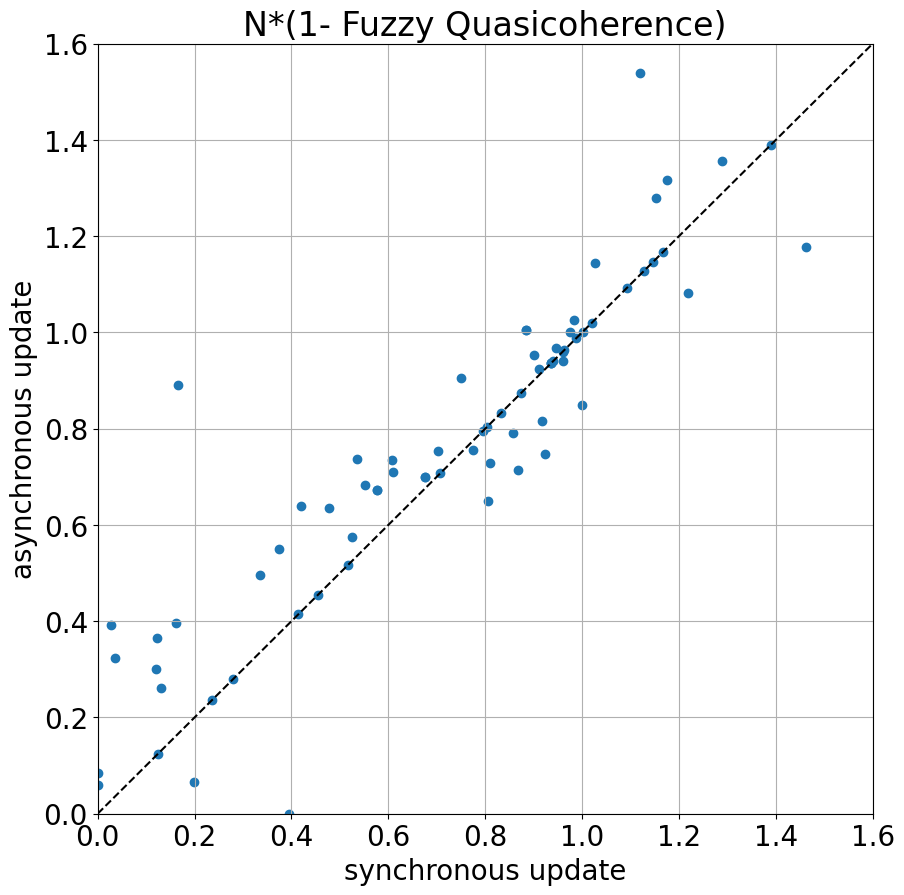

In [13]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(N*(1-QC['SFQC']),N*(1-QC['AFQC']))
ax.axline((1,1),slope=1,linestyle='--',color='k')
ax.grid()
ax.set_xlim(0.0,1.6)
ax.set_ylim(0.0,1.6)
ax.set_xlabel('synchronous update')
ax.set_ylabel('asynchronous update')
ax.set_title(f'N*(1- Fuzzy Quasicoherence)')
plt.show()

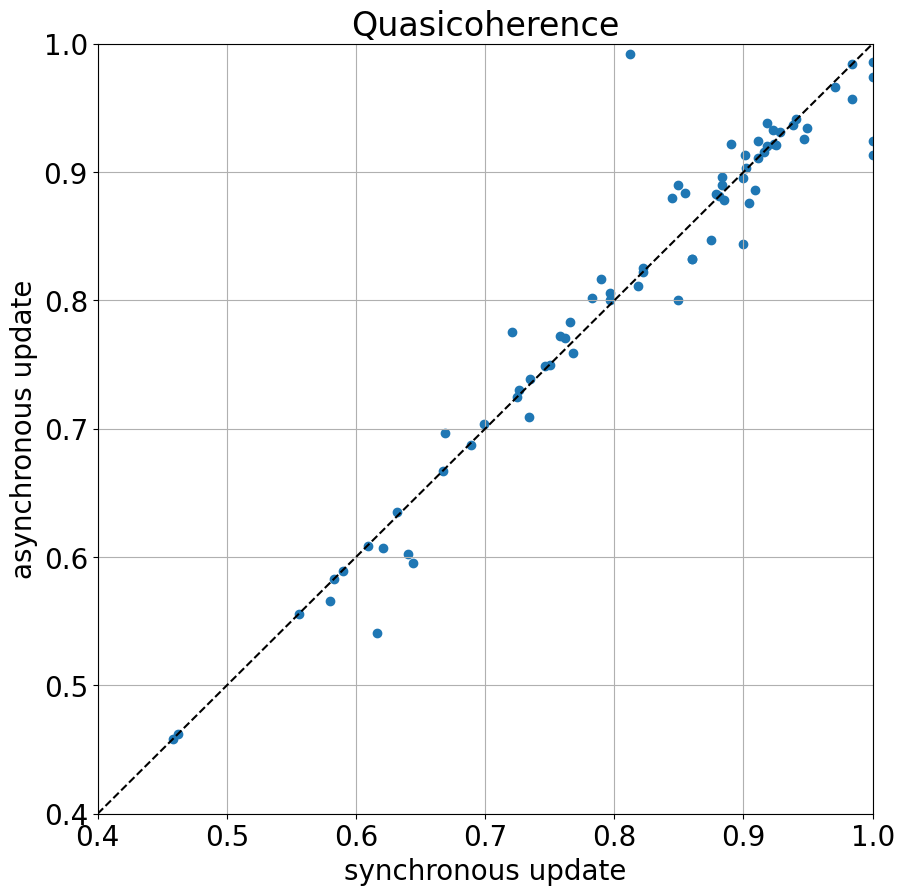

In [14]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(QC['SQC'],QC['AQC'])
ax.axline((1,1),slope=1,linestyle='--',color='k')
ax.grid()
ax.set_xlim(0.4,1.0)
ax.set_ylim(0.4,1.0)
ax.set_xlabel('synchronous update')
ax.set_ylabel('asynchronous update')
ax.set_title(f'Quasicoherence')
plt.show()

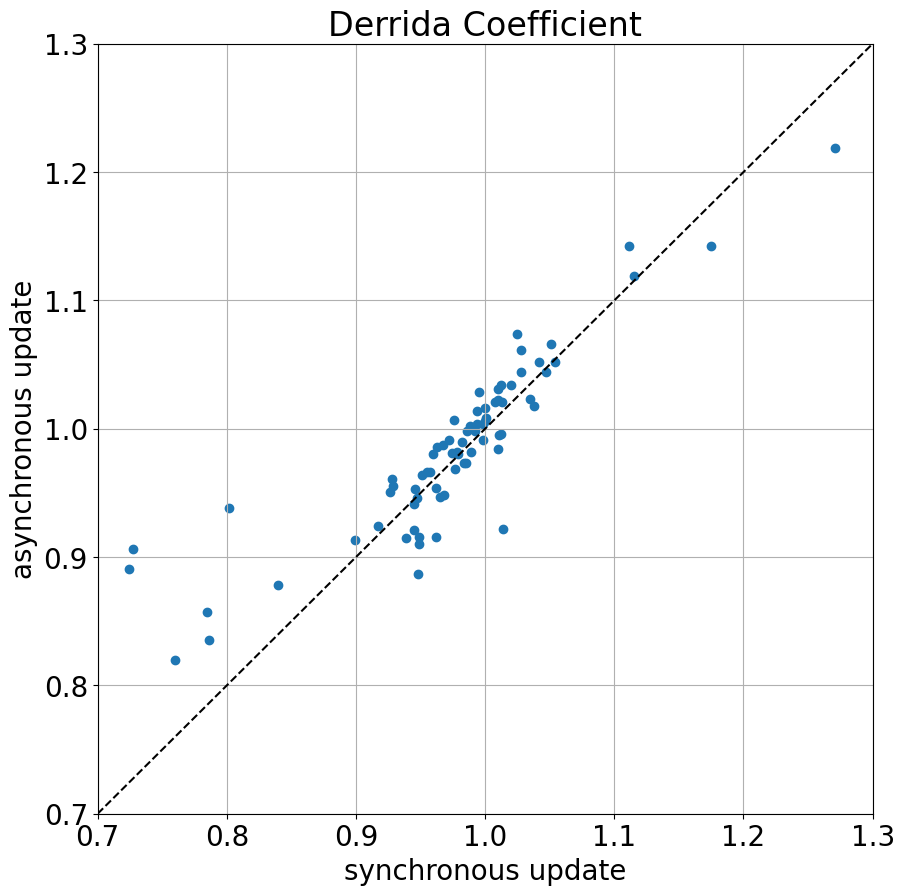

In [15]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(QC['SDC'],QC['ADC'])
ax.axline((1,1),slope=1,linestyle='--',color='k')
ax.grid()
ax.set_xlim(0.7,1.3)
ax.set_ylim(0.7,1.3)
ax.set_xlabel('synchronous update')
ax.set_ylabel('asynchronous update')
ax.set_title(f'Derrida Coefficient')
plt.show()

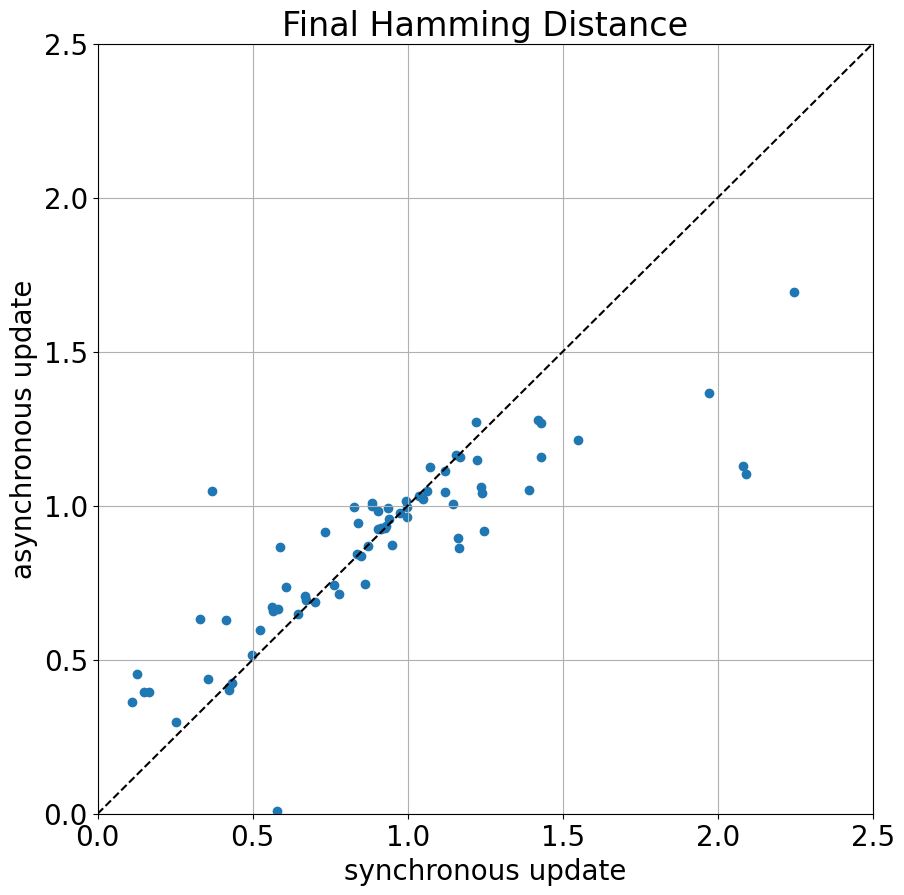

In [16]:
bfig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('white')
ax.scatter(QC['SFHD'],QC['AFHD'])
ax.axline((1,1),slope=1,linestyle='--',color='k')
ax.grid()
ax.set_xlim(0.,2.5)
ax.set_ylim(0.,2.5)
ax.set_xlabel('synchronous update')
ax.set_ylabel('asynchronous update')
ax.set_title(f'Final Hamming Distance')
plt.show()

In [17]:
QC['N(1-SFQC)']=QC['N']*(1-QC['SFQC'])
QC['N(1-AFQC)']=QC['N']*(1-QC['AFQC'])
QC.sort_values(by=['N(1-SFQC)'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
24,Fanconi anemia and checkpoint recovery,1.000,0.974,1.000,0.996,0.026,0.004,0.977,0.969,0.150,0.395,15,0.000,0.060
22,FA BRCA pathway,1.000,0.986,1.000,0.997,0.014,0.003,1.020,1.034,1.163,0.894,28,0.000,0.084
1,Arabidopsis thaliana Cell Cycle,1.000,0.913,0.998,0.972,0.087,0.026,1.271,1.219,1.548,1.213,14,0.028,0.392
10,Budding Yeast Cell Cycle 2009,1.000,0.924,0.998,0.982,0.076,0.016,1.115,1.119,2.092,1.103,18,0.036,0.324
64,T-LGL Survival Network 2011,0.900,0.895,0.998,0.995,0.005,0.003,0.939,0.915,0.110,0.362,60,0.120,0.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,Death Receptor Signaling,0.790,0.817,0.958,0.953,-0.027,0.005,1.028,1.044,1.421,1.278,28,1.176,1.316
61,T cell differentiation,0.758,0.772,0.947,0.953,-0.014,-0.006,1.035,1.023,1.236,1.062,23,1.219,1.081
2,Aurora Kinase A in Neuroblastoma,0.762,0.771,0.944,0.941,-0.009,0.003,1.051,1.066,1.973,1.367,23,1.288,1.357
56,Signal Transduction in Fibroblasts,0.855,0.884,0.990,0.990,-0.029,0.000,1.111,1.142,2.650,1.956,139,1.390,1.390


In [18]:
QC.sort_values(by=['SDC'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
12,CD4+ T Cell Differentiation and Plasticity,0.580,0.566,0.950,0.947,0.014,0.003,0.724,0.891,0.915,0.923,18,0.900,0.954
70,Tumour Cell Invasion and Migration,0.883,0.896,0.964,0.960,-0.013,0.004,0.727,0.906,1.220,1.273,32,1.152,1.280
6,BT474 Breast Cell Line Short-term ErbB Network,0.640,0.602,0.964,0.958,0.038,0.006,0.760,0.820,0.566,0.657,16,0.576,0.672
53,SKBR3 Breast Cell Line Short-term ErbB Network,0.616,0.541,0.962,0.954,0.075,0.008,0.785,0.857,0.607,0.735,16,0.608,0.736
28,HCC1954 Breast Cell Line Short-term ErbB Network,0.644,0.595,0.964,0.958,0.049,0.006,0.786,0.835,0.583,0.666,16,0.576,0.672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,Human Gonadal Sex Determination,0.901,0.913,0.923,0.938,-0.012,-0.015,1.054,1.052,1.429,1.157,19,1.463,1.178
56,Signal Transduction in Fibroblasts,0.855,0.884,0.990,0.990,-0.029,0.000,1.111,1.142,2.650,1.956,139,1.390,1.390
10,Budding Yeast Cell Cycle 2009,1.000,0.924,0.998,0.982,0.076,0.016,1.115,1.119,2.092,1.103,18,0.036,0.324
59,Stomatal Opening Model,0.879,0.883,0.977,0.977,-0.004,0.000,1.175,1.142,1.168,1.157,49,1.127,1.127


In [19]:
QC.sort_values(by=['SQC'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
30,HH Pathway of Drosophila Signaling Pathways,0.458,0.458,0.961,0.961,0.000,0.000,0.926,0.951,0.929,0.933,24,0.936,0.936
72,Wg Pathway of Drosophila Signalling Pathways,0.462,0.462,0.964,0.964,0.000,0.000,0.972,0.991,0.941,0.956,26,0.936,0.936
71,VEGF Pathway of Drosophila Signaling Pathway,0.556,0.556,0.957,0.958,0.000,-0.001,0.962,0.954,0.761,0.744,18,0.774,0.756
12,CD4+ T Cell Differentiation and Plasticity,0.580,0.566,0.950,0.947,0.014,0.003,0.724,0.891,0.915,0.923,18,0.900,0.954
66,TOL Regulatory Network,0.583,0.583,0.960,0.960,0.000,0.000,0.928,0.961,0.974,0.975,24,0.960,0.960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,T-LGL Survival Network 2011 Reduced Network,0.984,0.957,0.991,0.978,0.027,0.013,1.014,0.922,0.167,0.394,18,0.162,0.396
24,Fanconi anemia and checkpoint recovery,1.000,0.974,1.000,0.996,0.026,0.004,0.977,0.969,0.150,0.395,15,0.000,0.060
22,FA BRCA pathway,1.000,0.986,1.000,0.997,0.014,0.003,1.020,1.034,1.163,0.894,28,0.000,0.084
10,Budding Yeast Cell Cycle 2009,1.000,0.924,0.998,0.982,0.076,0.016,1.115,1.119,2.092,1.103,18,0.036,0.324


In [20]:
QC.sort_values(by=['AQC'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
30,HH Pathway of Drosophila Signaling Pathways,0.458,0.458,0.961,0.961,0.000,0.000,0.926,0.951,0.929,0.933,24,0.936,0.936
72,Wg Pathway of Drosophila Signalling Pathways,0.462,0.462,0.964,0.964,0.000,0.000,0.972,0.991,0.941,0.956,26,0.936,0.936
53,SKBR3 Breast Cell Line Short-term ErbB Network,0.616,0.541,0.962,0.954,0.075,0.008,0.785,0.857,0.607,0.735,16,0.608,0.736
71,VEGF Pathway of Drosophila Signaling Pathway,0.556,0.556,0.957,0.958,0.000,-0.001,0.962,0.954,0.761,0.744,18,0.774,0.756
12,CD4+ T Cell Differentiation and Plasticity,0.580,0.566,0.950,0.947,0.014,0.003,0.724,0.891,0.915,0.923,18,0.900,0.954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Bordetella bronchiseptica,0.971,0.966,0.994,0.998,0.005,-0.004,1.011,0.995,0.331,0.633,33,0.198,0.066
24,Fanconi anemia and checkpoint recovery,1.000,0.974,1.000,0.996,0.026,0.004,0.977,0.969,0.150,0.395,15,0.000,0.060
47,PC12 Cell Differentiation,0.984,0.984,0.998,0.998,0.000,0.000,0.949,0.910,0.424,0.401,62,0.124,0.124
22,FA BRCA pathway,1.000,0.986,1.000,0.997,0.014,0.003,1.020,1.034,1.163,0.894,28,0.000,0.084


In [21]:
QC.sort_values(by=['SFQC'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
18,Cortical Area Developmen,0.849,0.800,0.850,0.819,0.049,0.031,0.802,0.938,0.734,0.916,5,0.750,0.905
67,Toll Pathway of Drosophila Signaling Pathway,0.818,0.811,0.909,0.909,0.007,0.000,1.001,1.008,0.997,0.997,11,1.001,1.001
38,Lac Operon,0.768,0.759,0.921,0.912,0.009,0.009,0.998,1.004,1.071,1.125,13,1.027,1.144
32,Human Gonadal Sex Determination,0.901,0.913,0.923,0.938,-0.012,-0.015,1.054,1.052,1.429,1.157,19,1.463,1.178
44,Metabolic Interactions in the Gut Microbiome,0.590,0.589,0.924,0.923,0.001,0.001,1.010,0.984,0.904,0.926,12,0.912,0.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,PC12 Cell Differentiation,0.984,0.984,0.998,0.998,0.000,0.000,0.949,0.910,0.424,0.401,62,0.124,0.124
34,IL-1 Signaling,0.881,0.881,0.998,0.998,0.000,0.000,0.929,0.955,0.356,0.439,118,0.236,0.236
36,Influenza A Virus Replication Cycle,0.916,0.916,0.999,0.998,0.000,0.001,0.899,0.913,0.254,0.297,131,0.131,0.262
22,FA BRCA pathway,1.000,0.986,1.000,0.997,0.014,0.003,1.020,1.034,1.163,0.894,28,0.000,0.084


In [22]:
QC.sort_values(by=['AFQC'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
18,Cortical Area Developmen,0.849,0.800,0.850,0.819,0.049,0.031,0.802,0.938,0.734,0.916,5,0.750,0.905
67,Toll Pathway of Drosophila Signaling Pathway,0.818,0.811,0.909,0.909,0.007,0.000,1.001,1.008,0.997,0.997,11,1.001,1.001
38,Lac Operon,0.768,0.759,0.921,0.912,0.009,0.009,0.998,1.004,1.071,1.125,13,1.027,1.144
44,Metabolic Interactions in the Gut Microbiome,0.590,0.589,0.924,0.923,0.001,0.001,1.010,0.984,0.904,0.926,12,0.912,0.924
51,Regulation of the L-arabinose operon of Escher...,0.689,0.687,0.925,0.923,0.002,0.002,1.038,1.018,0.996,1.016,13,0.975,1.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,PC12 Cell Differentiation,0.984,0.984,0.998,0.998,0.000,0.000,0.949,0.910,0.424,0.401,62,0.124,0.124
34,IL-1 Signaling,0.881,0.881,0.998,0.998,0.000,0.000,0.929,0.955,0.356,0.439,118,0.236,0.236
7,Bordetella bronchiseptica,0.971,0.966,0.994,0.998,0.005,-0.004,1.011,0.995,0.331,0.633,33,0.198,0.066
36,Influenza A Virus Replication Cycle,0.916,0.916,0.999,0.998,0.000,0.001,0.899,0.913,0.254,0.297,131,0.131,0.262


In [23]:
QC.sort_values(by=['dQC'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
15,Cell Cycle Transcription by Coupled CDK and Ne...,0.812,0.992,0.956,1.000,-0.180,-0.044,0.948,0.887,0.577,0.010,9,0.396,0.000
9,Budding Yeast Cell Cycle,0.721,0.775,0.952,0.953,-0.054,-0.001,1.013,1.021,1.121,1.044,20,0.960,0.940
26,Guard Cell Abscisic Acid Signaling,0.849,0.890,0.979,0.983,-0.041,-0.004,0.994,1.014,1.391,1.052,44,0.924,0.748
69,Trichostrongylus retortaeformis,0.845,0.880,0.973,0.971,-0.035,0.002,1.012,1.034,0.905,0.984,26,0.702,0.754
49,Pro-inflammatory Tumor Microenvironment in Acu...,0.890,0.922,0.969,0.975,-0.032,-0.006,0.967,0.987,0.861,0.746,26,0.806,0.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,HCC1954 Breast Cell Line Short-term ErbB Network,0.644,0.595,0.964,0.958,0.049,0.006,0.786,0.835,0.583,0.666,16,0.576,0.672
43,Mammalian Cell Cycle 2006,0.900,0.844,0.939,0.929,0.056,0.010,1.025,1.074,0.841,0.945,10,0.610,0.710
53,SKBR3 Breast Cell Line Short-term ErbB Network,0.616,0.541,0.962,0.954,0.075,0.008,0.785,0.857,0.607,0.735,16,0.608,0.736
10,Budding Yeast Cell Cycle 2009,1.000,0.924,0.998,0.982,0.076,0.016,1.115,1.119,2.092,1.103,18,0.036,0.324


In [24]:
QC.sort_values(by=['dFQC'])

,name,SQC,AQC,SFQC,AFQC,dQC,dFQC,SDC,ADC,SFHD,AFHD,N,N(1-SFQC),N(1-AFQC)
15,Cell Cycle Transcription by Coupled CDK and Ne...,0.812,0.992,0.956,1.000,-0.180,-0.044,0.948,0.887,0.577,0.010,9,0.396,0.000
32,Human Gonadal Sex Determination,0.901,0.913,0.923,0.938,-0.012,-0.015,1.054,1.052,1.429,1.157,19,1.463,1.178
49,Pro-inflammatory Tumor Microenvironment in Acu...,0.890,0.922,0.969,0.975,-0.032,-0.006,0.967,0.987,0.861,0.746,26,0.806,0.650
61,T cell differentiation,0.758,0.772,0.947,0.953,-0.014,-0.006,1.035,1.023,1.236,1.062,23,1.219,1.081
26,Guard Cell Abscisic Acid Signaling,0.849,0.890,0.979,0.983,-0.041,-0.004,0.994,1.014,1.391,1.052,44,0.924,0.748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,T-LGL Survival Network 2011 Reduced Network,0.984,0.957,0.991,0.978,0.027,0.013,1.014,0.922,0.167,0.394,18,0.162,0.396
10,Budding Yeast Cell Cycle 2009,1.000,0.924,0.998,0.982,0.076,0.016,1.115,1.119,2.092,1.103,18,0.036,0.324
39,Lymphoid and myeloid cell specification and tr...,0.904,0.876,0.995,0.973,0.028,0.022,1.028,1.061,0.368,1.048,33,0.165,0.891
1,Arabidopsis thaliana Cell Cycle,1.000,0.913,0.998,0.972,0.087,0.026,1.271,1.219,1.548,1.213,14,0.028,0.392


In [25]:
QC['SQC'].describe()

count    74.000000
mean      0.811419
std       0.133098
min       0.458000
25%       0.728000
50%       0.849000
75%       0.911000
max       1.000000
Name: SQC, dtype: float64

In [26]:
QC['AQC'].describe()

count    74.000000
mean      0.809257
std       0.134275
min       0.458000
25%       0.732250
50%       0.838000
75%       0.919000
max       0.992000
Name: AQC, dtype: float64

In [27]:
import pystablemotifs as psm
import pyboolnet as pbn

CDK_Model_rules = '''
ACE2,	SFF
YHP1,	!(!MBF & !SBF)
YOX1,	MBF & SBF
MBF,	CLN3
SBF,	!YHP1 & !YOX1 & CLN3 | !YHP1 & !YOX1 & MBF
SWI5,	SFF
HCM1,	MBF & SBF
SFF,	SBF & HCM1
CLN3,	ACE2 & !YHP1 & !YOX1 & SWI5
'''

primes = psm.format.create_primes(CDK_Model_rules)
ar = psm.AttractorRepertoire.from_primes(primes)
print("asynchronous:") # according to pystablemotifs, there's only one attractor
ar.summary()
print()

print("synchronous oscillation:") # according to cubewalkers, this has basin ~20-25% of the statespace
s='000001010'
for _ in range(10):
    s=pbn.state_transition_graphs.successor_synchronous(primes,s)
    print(s)


asynchronous:
There is 1 attractor.
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}


synchronous oscillation:
{'ACE2': 1, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 1, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 1, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 1, 'SBF': 1, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 1, 'MBF': 0, 'SBF': 1, 'SFF': 0, 'SWI5': 0, 'YHP1': 1, 'YOX1': 1}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 1, 'SWI5': 0, 'YHP1': 1, 'YOX1': 0}
{'ACE2': 1, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 1, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 1, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 1, 'SBF': 1, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 1, 'MBF': 0, 'SBF': 1, 'SFF': 0, 

In [28]:
import pystablemotifs as psm
import pyboolnet as pbn

CDK_Model_rules_alt = '''
ACE2,   SFF
YHP1,   MBF | SBF
YOX1,   MBF & SBF
MBF,    CLN3
SBF,    CLN3 & !YOX1 | CLN3 & !YHP1  |  MBF & !YOX1 | MBF & !YHP1
SWI5,   SFF
HCM1,   MBF & SBF
SFF,    SBF & HCM1
CLN3,   ACE2 & SWI5 & !YOX1  | ACE2 & SWI5 & !YHP1
'''

primes_alt = psm.format.create_primes(CDK_Model_rules_alt)
ar_alt = psm.AttractorRepertoire.from_primes(primes_alt)
print("asynchronous:") # according to pystablemotifs, there's only one attractor
ar_alt.summary()
print()

print("synchronous oscillation:") # according to cubewalkers, this has basin ~20-25% of the statespace
s='000001010'
for _ in range(10):
    s=pbn.state_transition_graphs.successor_synchronous(primes_alt,s)
    print(s)


asynchronous:
There is 1 attractor.
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}


synchronous oscillation:
{'ACE2': 1, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 1, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 1, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 1, 'SBF': 1, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 1, 'MBF': 0, 'SBF': 1, 'SFF': 0, 'SWI5': 0, 'YHP1': 1, 'YOX1': 1}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 1, 'SWI5': 0, 'YHP1': 1, 'YOX1': 0}
{'ACE2': 1, 'CLN3': 0, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 1, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 1, 'HCM1': 0, 'MBF': 0, 'SBF': 0, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 0, 'MBF': 1, 'SBF': 1, 'SFF': 0, 'SWI5': 0, 'YHP1': 0, 'YOX1': 0}
{'ACE2': 0, 'CLN3': 0, 'HCM1': 1, 'MBF': 0, 'SBF': 1, 'SFF': 0, 

In [29]:
rules_simple='''
T, Z
X, T
Y, Z
Z, X & ! Y
'''

primes_simple=psm.format.create_primes(rules_simple)
ar_simple = psm.AttractorRepertoire.from_primes(primes_simple)
print("asynchronous:")
ar_simple.summary()
print()

print("synchronous oscillation:") # according to cubewalkers, this has basin ~20-25% of the statespace
s='0001'
for _ in range(6):
    s=pbn.state_transition_graphs.successor_synchronous(primes_simple,s)
    print(s)

asynchronous:
There is 1 attractor.
{'T': 0, 'X': 0, 'Y': 0, 'Z': 0}


synchronous oscillation:
{'T': 1, 'X': 0, 'Y': 1, 'Z': 0}
{'T': 0, 'X': 1, 'Y': 0, 'Z': 0}
{'T': 0, 'X': 0, 'Y': 0, 'Z': 1}
{'T': 1, 'X': 0, 'Y': 1, 'Z': 0}
{'T': 0, 'X': 1, 'Y': 0, 'Z': 0}
{'T': 0, 'X': 0, 'Y': 0, 'Z': 1}


In [30]:
import pystablemotifs as psm
import pyboolnet as pbn

Arabidopsis_CellCycle_rules='''
MYB77,	!RBR & E2Fb | !KRP1 & CYCD3_1 & E2Fb
KRP1,	!(SCF & CYCA2_3 & CDKB1_1 | !MYB77 & !MYB3R1_4)
CYCB1_1,	MYB77 & !APC_C | !RBR & !E2Fc & !APC_C & E2Fb | !APC_C & MYB3R1_4 | !KRP1 & CYCD3_1 & !E2Fc & !APC_C & E2Fb
E2Fe,	!(!MYB77 & E2Fc & !E2Fb | !MYB77 & RBR & !CYCD3_1 & E2Fc | !MYB77 & KRP1 & RBR & E2Fc)
RBR,	KRP1 & MYB3R1_4 | !CYCD3_1 & MYB3R1_4 | !RBR & !CYCD3_1 & E2Fa | KRP1 & !RBR & E2Fa
CYCD3_1,	!SCF
E2Fa,	!(!E2Fa & E2Fc | CYCA2_3 & CDKB1_1)
SCF,	!KRP1 & CYCD3_1 & !APC_C & E2Fb | !RBR & !APC_C & E2Fb | !APC_C & MYB3R1_4
E2Fc,	!(!E2Fa & !MYB3R1_4 | !KRP1 & CYCD3_1 & SCF | RBR & !MYB3R1_4)
APC_C,	MYB77 & !E2Fe | !E2Fe & MYB3R1_4 | !E2Fe & !RBR & E2Fa
MYB3R1_4,	!(!MYB77 & !CYCB1_1 | !MYB77 & !MYB3R1_4 | !MYB77 & KRP1)
CYCA2_3,	MYB77 & !APC_C | !APC_C & MYB3R1_4
E2Fb,	!RBR & E2Fa
CDKB1_1,	!(!MYB77 & E2Fc & !MYB3R1_4 | !MYB77 & !MYB3R1_4 & !E2Fb | !MYB77 & RBR & !CYCD3_1 & !MYB3R1_4 | !MYB77 & KRP1 & RBR & !MYB3R1_4)
'''
primes_acc = psm.format.create_primes(Arabidopsis_CellCycle_rules)
ar_acc = psm.AttractorRepertoire.from_primes(primes_acc)
print("asynchronous:") # according to pystablemotifs, there's only one attractor (this is exact)
ar_acc.summary()
print()

asynchronous:
There is 1 attractor.
{'APC_C': 'X', 'CDKB1_1': 'X', 'CYCA2_3': 'X', 'CYCB1_1': 'X', 'CYCD3_1': 'X', 'E2Fa': 'X', 'E2Fb': 'X', 'E2Fc': 'X', 'E2Fe': 'X', 'KRP1': 'X', 'MYB3R1_4': 'X', 'MYB77': 'X', 'RBR': 'X', 'SCF': 'X'}




In [31]:
rules_AK = '''AK* = X or Y
X* = AK
Y* = AK and not Z
Z* = Y'''
for delay in range(6):
    if delay > 0:
        rule_lines = rules_AK.split('\n')
        if delay == 1:
            rule_lines[-1] = f'D{delay}* = Y'
        else:
            rule_lines[-1] = f'D{delay}* = D{delay-1}'
        rule_lines.append(f'Z* = D{delay}')
        rules_AK = '\n'.join(rule_lines)
    
    print("Rules")
    print(rules_AK)
        
    model_AK = cw.Model(rules_AK)
    model_AK.n_time_steps = 10000
    model_AK.n_walkers = 4096

    model_AK.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.synchronous)
    sync_avg = cp.mean(model_AK.trajectories,axis=0)
    model_AK.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.asynchronous)
    async_avg = cp.mean(model_AK.trajectories,axis=0)
    
    print(f'sync:  {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model_AK.varnames,sync_avg)])}')
    print(f'async: {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model_AK.varnames,async_avg)])}')

    print('-'*10)
    print()


Rules
AK* = X or Y
X* = AK
Y* = AK and not Z
Z* = Y
sync:  {'AK': 0.631, 'X': 0.631, 'Y': 0.315, 'Z': 0.315}
async: {'AK': 0.62, 'X': 0.62, 'Y': 0.31, 'Z': 0.309}
----------

Rules
AK* = X or Y
X* = AK
Y* = AK and not Z
D1* = Y
Z* = D1
sync:  {'AK': 0.629, 'X': 0.629, 'Y': 0.44, 'D1': 0.44, 'Z': 0.44}
async: {'AK': 0.627, 'X': 0.627, 'Y': 0.313, 'D1': 0.313, 'Z': 0.313}
----------

Rules
AK* = X or Y
X* = AK
Y* = AK and not Z
D1* = Y
D2* = D1
Z* = D2
sync:  {'AK': 0.623, 'X': 0.623, 'Y': 0.311, 'D1': 0.311, 'D2': 0.311, 'Z': 0.311}
async: {'AK': 0.612, 'X': 0.612, 'Y': 0.306, 'D1': 0.306, 'D2': 0.306, 'Z': 0.306}
----------

Rules
AK* = X or Y
X* = AK
Y* = AK and not Z
D1* = Y
D2* = D1
D3* = D2
Z* = D3
sync:  {'AK': 0.622, 'X': 0.622, 'Y': 0.439, 'D1': 0.439, 'D2': 0.439, 'D3': 0.439, 'Z': 0.439}
async: {'AK': 0.635, 'X': 0.635, 'Y': 0.318, 'D1': 0.318, 'D2': 0.317, 'D3': 0.317, 'Z': 0.317}
----------

Rules
AK* = X or Y
X* = AK
Y* = AK and not Z
D1* = Y
D2* = D1
D3* = D2
D4* = D3
Z* =

In [32]:
rules_AK = '''AK*=!AK
Y* = AK and not Z
Z* = Y'''
for delay in range(6):
    if delay > 0:
        rule_lines = rules_AK.split('\n')
        if delay == 1:
            rule_lines[-1] = f'D{delay}* = Y'
        else:
            rule_lines[-1] = f'D{delay}* = D{delay-1}'
        rule_lines.append(f'Z* = D{delay}')
        rules_AK = '\n'.join(rule_lines)
    
    print("Rules")
    print(rules_AK)
        
    model_AK = cw.Model(rules_AK)
    model_AK.n_time_steps = 10000
    model_AK.n_walkers = 4096

    model_AK.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.synchronous)
    sync_avg = cp.mean(model_AK.trajectories,axis=0)
    model_AK.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.asynchronous)
    async_avg = cp.mean(model_AK.trajectories,axis=0)
    
    print(f'sync:  {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model_AK.varnames,sync_avg)])}')
    print(f'async: {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model_AK.varnames,async_avg)])}')

    print('-'*10)
    print()

Rules
AK*=!AK
Y* = AK and not Z
Z* = Y
sync:  {'AK': 0.5, 'Y': 0.25, 'Z': 0.25}
async: {'AK': 0.5, 'Y': 0.321, 'Z': 0.321}
----------

Rules
AK*=!AK
Y* = AK and not Z
D1* = Y
Z* = D1
sync:  {'AK': 0.5, 'Y': 0.5, 'D1': 0.5, 'Z': 0.5}
async: {'AK': 0.5, 'Y': 0.329, 'D1': 0.328, 'Z': 0.328}
----------

Rules
AK*=!AK
Y* = AK and not Z
D1* = Y
D2* = D1
Z* = D2
sync:  {'AK': 0.5, 'Y': 0.25, 'D1': 0.25, 'D2': 0.25, 'Z': 0.25}
async: {'AK': 0.5, 'Y': 0.333, 'D1': 0.334, 'D2': 0.334, 'Z': 0.333}
----------

Rules
AK*=!AK
Y* = AK and not Z
D1* = Y
D2* = D1
D3* = D2
Z* = D3
sync:  {'AK': 0.5, 'Y': 0.5, 'D1': 0.5, 'D2': 0.5, 'D3': 0.5, 'Z': 0.5}
async: {'AK': 0.499, 'Y': 0.332, 'D1': 0.333, 'D2': 0.333, 'D3': 0.332, 'Z': 0.332}
----------

Rules
AK*=!AK
Y* = AK and not Z
D1* = Y
D2* = D1
D3* = D2
D4* = D3
Z* = D4
sync:  {'AK': 0.5, 'Y': 0.25, 'D1': 0.25, 'D2': 0.25, 'D3': 0.25, 'D4': 0.25, 'Z': 0.25}
async: {'AK': 0.5, 'Y': 0.333, 'D1': 0.333, 'D2': 0.333, 'D3': 0.333, 'D4': 0.333, 'Z': 0.333}
---

In [33]:
rules = '''
AK,     PLK1 & AKP
AKP,    !PP2A
CDK,    !CYT & (AK | PLK1)
CYT,    CDK
PLK1,   AK
PP2A,   !AK & !CDK & ! CYT
'''
print("RULES")
print(rules)
primes = psm.format.create_primes(rules)
ar = psm.AttractorRepertoire.from_primes(primes)
print("asynchronous:") # according to pystablemotifs, there's only one attractor (this is exact)
ar.summary()
print()

print("synchronous oscillation:") # according to cubewalkers, this has basin ~20-25% of the statespace
s='010110'
for _ in range(5):
    s=pbn.state_transition_graphs.successor_synchronous(primes,s)
    print(s)
print()

print("node average values:")
model = cw.Model(rules)
model.n_time_steps=10000
model.n_walkers=4096
model.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.synchronous)
sync_avg = cp.mean(model.trajectories,axis=0)
model.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.asynchronous)
async_avg = cp.mean(model.trajectories,axis=0)
print(f'sync:  {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model.varnames,sync_avg)])}')
print(f'async: {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model.varnames,async_avg)])}')

RULES

AK,     PLK1 & AKP
AKP,    !PP2A
CDK,    !CYT & (AK | PLK1)
CYT,    CDK
PLK1,   AK
PP2A,   !AK & !CDK & ! CYT

asynchronous:
There are 2 attractors.
{'AK': 0, 'AKP': 0, 'CDK': 0, 'CYT': 0, 'PLK1': 0, 'PP2A': 1}

{'AK': 1, 'AKP': 1, 'CDK': 'X', 'CYT': 'X', 'PLK1': 1, 'PP2A': 0}


synchronous oscillation:
{'AK': 1, 'AKP': 1, 'CDK': 0, 'CYT': 0, 'PLK1': 0, 'PP2A': 0}
{'AK': 0, 'AKP': 1, 'CDK': 1, 'CYT': 0, 'PLK1': 1, 'PP2A': 0}
{'AK': 1, 'AKP': 1, 'CDK': 1, 'CYT': 1, 'PLK1': 0, 'PP2A': 0}
{'AK': 0, 'AKP': 1, 'CDK': 0, 'CYT': 1, 'PLK1': 1, 'PP2A': 0}
{'AK': 1, 'AKP': 1, 'CDK': 0, 'CYT': 0, 'PLK1': 0, 'PP2A': 0}

node average values:
sync:  {'AK': 0.156, 'AKP': 0.252, 'CDK': 0.126, 'CYT': 0.126, 'PLK1': 0.156, 'PP2A': 0.748}
async: {'AK': 0.323, 'AKP': 0.323, 'CDK': 0.161, 'CYT': 0.162, 'PLK1': 0.323, 'PP2A': 0.677}


In [34]:
rules = '''
AK,     PLK1 & AKP
AKP,    !PP2A
CDK,    !CDK & (AK | PLK1)
PLK1,   AK
PP2A,   !AK & !CDK
'''
print("RULES")
print(rules)
primes = psm.format.create_primes(rules)
ar = psm.AttractorRepertoire.from_primes(primes)
print("asynchronous:") # according to pystablemotifs, there's only one attractor (this is exact)
ar.summary()
print()

print("synchronous oscillation:") # according to cubewalkers, this has basin ~20-25% of the statespace
s='01110'
for _ in range(5):
    s=pbn.state_transition_graphs.successor_synchronous(primes,s)
    print(s)
print()

print("node average values:")
model = cw.Model(rules)
model.n_time_steps=10000
model.n_walkers=4096
model.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.synchronous)
sync_avg = cp.mean(model.trajectories,axis=0)
model.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.asynchronous)
async_avg = cp.mean(model.trajectories,axis=0)
print(f'sync:  {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model.varnames,sync_avg)])}')
print(f'async: {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model.varnames,async_avg)])}')

RULES

AK,     PLK1 & AKP
AKP,    !PP2A
CDK,    !CDK & (AK | PLK1)
PLK1,   AK
PP2A,   !AK & !CDK

asynchronous:
There are 2 attractors.
{'AK': 0, 'AKP': 0, 'CDK': 0, 'PLK1': 0, 'PP2A': 1}

{'AK': 1, 'AKP': 1, 'CDK': 'X', 'PLK1': 1, 'PP2A': 0}


synchronous oscillation:
{'AK': 1, 'AKP': 1, 'CDK': 0, 'PLK1': 0, 'PP2A': 0}
{'AK': 0, 'AKP': 1, 'CDK': 1, 'PLK1': 1, 'PP2A': 0}
{'AK': 1, 'AKP': 1, 'CDK': 0, 'PLK1': 0, 'PP2A': 0}
{'AK': 0, 'AKP': 1, 'CDK': 1, 'PLK1': 1, 'PP2A': 0}
{'AK': 1, 'AKP': 1, 'CDK': 0, 'PLK1': 0, 'PP2A': 0}

node average values:
sync:  {'AK': 0.151, 'AKP': 0.241, 'CDK': 0.12, 'PLK1': 0.151, 'PP2A': 0.759}
async: {'AK': 0.309, 'AKP': 0.309, 'CDK': 0.155, 'PLK1': 0.309, 'PP2A': 0.691}


In [35]:
rules = '''
AK,     PLK1 & !PP2A
CDK,    !CDK & (AK | PLK1)
PLK1,   AK
PP2A,   !AK & !CDK
'''
print("RULES")
print(rules)
primes = psm.format.create_primes(rules)
ar = psm.AttractorRepertoire.from_primes(primes)
print("asynchronous:") # according to pystablemotifs, there's only one attractor (this is exact)
ar.summary()
print()

print("synchronous oscillation:") # according to cubewalkers, this has basin ~20-25% of the statespace
s='0110'
for _ in range(5):
    s=pbn.state_transition_graphs.successor_synchronous(primes,s)
    print(s)
print()

print("node average values:")
model = cw.Model(rules)
model.n_time_steps=10000
model.n_walkers=4096
model.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.synchronous)
sync_avg = cp.mean(model.trajectories,axis=0)
model.simulate_ensemble(T_window=1000,averages_only=True,maskfunction=cw.update_schemes.asynchronous)
async_avg = cp.mean(model.trajectories,axis=0)
print(f'sync:  {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model.varnames,sync_avg)])}')
print(f'async: {dict([(n,float(str(cp.round(v,3)))) for n,v in zip(model.varnames,async_avg)])}')

RULES

AK,     PLK1 & !PP2A
CDK,    !CDK & (AK | PLK1)
PLK1,   AK
PP2A,   !AK & !CDK

asynchronous:
There are 2 attractors.
{'AK': 0, 'CDK': 0, 'PLK1': 0, 'PP2A': 1}

{'AK': 1, 'CDK': 'X', 'PLK1': 1, 'PP2A': 0}


synchronous oscillation:
{'AK': 1, 'CDK': 0, 'PLK1': 0, 'PP2A': 0}
{'AK': 0, 'CDK': 1, 'PLK1': 1, 'PP2A': 0}
{'AK': 1, 'CDK': 0, 'PLK1': 0, 'PP2A': 0}
{'AK': 0, 'CDK': 1, 'PLK1': 1, 'PP2A': 0}
{'AK': 1, 'CDK': 0, 'PLK1': 0, 'PP2A': 0}

node average values:
sync:  {'AK': 0.37, 'CDK': 0.311, 'PLK1': 0.37, 'PP2A': 0.508}
async: {'AK': 0.37, 'CDK': 0.185, 'PLK1': 0.37, 'PP2A': 0.63}
